In [1]:
from math import exp
from sklearn.preprocessing import OneHotEncoder
from typing import List
from tqdm.notebook import tqdm
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import dill


# Import mnist784
from sklearn.datasets import fetch_openml
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

# Untuk downscale gambar, maaf kak, laptop kentang kami menderita karena ukuran 28x28
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import tensorflow as tf

In [12]:
class Neuron:
    def __init__(self, value, _children=(), _op='', label=''):
        self.value = value
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label # for visualization

    def __repr__(self):
        stringVal = f"{self.value}"
        return stringVal

    def __add__(self,other):
        other = other if isinstance(other, Neuron) else Neuron(other)
        out = Neuron(self.value + other.value, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self,other):
        other = other if isinstance(other, Neuron) else Neuron(other)
        out = Neuron(self.value * other.value, (self, other), '*')
        def _backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Neuron(self.value**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.value ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Neuron) else Neuron(other)
        return self * other**-1

    def exp(self, pos=1):
        x = self.value*pos
        out = Neuron(exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.value * out.grad * pos
        out._backward = _backward
        return out

    def log(self):
        x = self.value
        out = Neuron(np.log(x), (self,), 'log')
        def _backward():
            self.grad += (1/x) * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other): # other + self
        return self + other

    def __rsub__(self, other): # other - self
        return -(self - other)

    def __rmul__(self, other): # other * self
        return self * other

    def __rtruediv__(self, other): # other / self
        other = other if isinstance(other, Neuron) else Neuron(other)
        return other * self**-1

    def __lt__(self,other):
        if(isinstance(other,Neuron)):
            return self.value < other.value
        else:
            return self.value < other

    def __gt__(self,other):
        if(isinstance(other,Neuron)):
            return self.value > other.value
        else:
            return self.value > other

    def __le__(self,other):
        if(isinstance(other,Neuron)):
            return self.value <= other.value
        else:
            return self.value <= other

    def __ge__(self,other):
        if(isinstance(other,Neuron)):
            return self.value >= other.value
        else:
            return self.value >= other


    def backward(self):
        topology = []
        visited = set()
        def build_topology(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topology(child)
                topology.append(v)
        build_topology(self)

        self.grad = 1.0
        for node in reversed(topology):
            node._backward()

    def __float__(self):
        return float(self.value)

    def __format__(self, other):
        return format(float(self), other)

    def __round__(self,other):
        return round(self.value,other)

    def getGrad(self):
        return float(self.grad)

    def hello(self):
        print("hello")


# Wrapper, propose better name?
# Maybe MLP? (multi layer perceptron, since it is a wrapper for mutliple layers of neurons)
class LayerWrapper:
    valid_loss_func = {"mse","bce","cce"}

    def __init__(self,
                 layer_neuron_width:List[int],
                 activation_function:str = "linear",
                 weight_initialization:str = "uniform",
                 loss_function:str = "mse",
                 uniform_parameter: tuple = (0, 10, 0),
                 normal_parameter: tuple = (5, 3, 0),
                 batch_size: int = 1,
                 learning_rate: float = 0.1,
                 max_epoch: int = 1,
                 verbose: int = 0,
                 regularization_type: str = "Unregularized",
                 regularization_lambda: float = 0
                 ):

        self.learning_rate = learning_rate
        self.loss_function = loss_function
        self.layer_selector:List[Layers] = []
        self.layer_count = len(layer_neuron_width)
        self.loss = Neuron(0)
        self.error_acc = Neuron(0)
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.verbose = verbose
        self.regularization_type: str = regularization_type,
        self.regularization_lambda: float = regularization_lambda
        Layers(
            wrapper=self,
            layer_neuron_width=layer_neuron_width,
            activation_function=activation_function,
            weight_initialization=weight_initialization,
            uniform_parameter=uniform_parameter,
            normal_parameter=normal_parameter
        )

        self.train_class_value = LayerWrapper.neuronGenerator(np.zeros,(len(self.layer_selector[-1]._neurons)))
        self.validation_class_value = LayerWrapper.neuronGenerator(np.zeros,(len(self.layer_selector[-1]._neurons)))

    def verboseprint(self, *args: str, nl: bool=True):
        print(*args, end='\n' if nl else '	') if self.verbose else None

    def save(self,filename):
        with open(f"{filename}","wb") as file:
            dill.dump(self,file)

    def load(self,filename):
        with open(f"{filename}","rb") as file:
            self = dill.load(file)

    # Function, dengan retval
    @staticmethod
    def neuronGenerator(generator, *args, **kwargs):
        value = generator(*args, **kwargs)
        return np.vectorize(Neuron)(value)

    def loss_func(self,Y_pred,Y_target) -> float:
        if self.loss_function == "mse":
            return LayerWrapper.meanSquareError(Y_pred,Y_target)
        elif self.loss_function == "bce":
            return LayerWrapper.binaryCrossEntropy(Y_pred,Y_target)
        elif self.loss_function == "cce":
            return LayerWrapper.categoricalCrossEntropy(Y_pred,Y_target)

    @staticmethod
    def meanSquareError(Y_pred,Y_target) -> float:
        tempPredictClass = Y_pred
        tempTrueClass = Y_target
        subtracted = np.subtract(tempTrueClass,tempPredictClass)
        squared = np.square(subtracted)
        return np.sum(squared)/len(tempTrueClass)

    @staticmethod
    def binaryCrossEntropy(Y_pred: "Layers",Y_target) -> float:
        tempPredictClass = Y_pred
        tempTrueClass = Y_target
        logFunc = np.vectorize(lambda n: n.log())
        oneMinTarget = np.subtract(1, Y_target)
        # print(tempPredictClass)
        oneMinPredict = np.subtract(1, tempPredictClass)
        logPredictedClass = logFunc(tempPredictClass)
        logOneMinPredict = logFunc(oneMinPredict)
        return -np.sum(np.add(tempTrueClass*logPredictedClass, oneMinTarget*logOneMinPredict))/len(tempTrueClass)

    @staticmethod
    def categoricalCrossEntropy(Y_pred: "Layers",Y_target) -> float:
        # Categorical Cross Entropy target will be an array cause the target will be encoded
        # For example if we have 3 classes 0, 1, 2 and the target for this instance is 1, then the target will be [0, 1, 0]
        # The predict or the output we get must be probability for every classes in target
        # This error formula only can be used with softmax activation function
        # encoder = OneHotEncoder(sparse_output=False)
        # tempTrueClass = encoder.fit_transform(np.array(Y_target).reshape(-1, 1))
        # tempPredictClass = encoder.fit_transform(np.array(Y_pred).reshape(-1, 1))
        # tempPredictClass = Y_pred   # ingat ini array of list yh, nvm better gua encode di dalem sini aja
        # tempTrueClass = Y_target    # ini juga yh
        logFunc = np.vectorize(lambda n: n.log())
        logPredictedClass = logFunc(Y_pred)
        return -np.sum(np.multiply(Y_target, logPredictedClass))/len(Y_target)


    def predict(self,inputVal:List[float]):
        # need progress bar in this one too
        for x,y in zip(self.layer_selector[0],inputVal):
            x.value = y
        self.feedforward()
        return self.getPredResult()

    def getPredResult(self):
        return self.layer_selector[-1]

    def __getitem__(self, idx):
        return self.layer_selector[idx]

    def __repr__(self):
        return f"{self.layer_selector}"


    # Procedure, getter, setter or something else

    def regularization(self):
            sum = 0
            if self.regularization_type == "L1":
                for layer in self.layer_selector:
                    abs_val = np.abs(layer)
                    sum += np.sum(abs_val)
            elif self.regularization_type == "L2":
                for layer in self.layer_selector:
                    square_val = np.square(layer)
                    sum += np.sum(square_val)
            self.loss += self.regularization_lambda*sum  # error_accumulate atau loss, idk need to test it

    def feedforward(self):
        self.layer_selector[0].feedforward()

    def batchHelper(self,
                batch_input: np.ndarray,
                batch_class: np.ndarray,
                ):
        self.loss = Neuron(0)
        self.error_acc = 0
        total_samples = len(batch_input)
        i = 0
        while i < total_samples:
            self.loss = Neuron(0)
            batch_end = min(i + self.batch_size, total_samples)
            for j in range(i, batch_end):
                input_sample = list(batch_input[j])
                target_sample = list(batch_class[j])
                self.layer_selector[0].setLayerNeurons(input_sample)
                self.layer_selector[0].feedforward()
                Y_pred = self.layer_selector[-1]._neurons
                Y_target = self.neuronGenerator(np.array, target_sample)
                loss = self.loss_func(Y_pred=Y_pred, Y_target=Y_target)
                self.loss += loss
                self.error_acc += loss
            self.regularization()
            self.loss.backward()
            self.updateWeightHelper()
            i += self.batch_size

    def validate(self,X_val,Y_val):
        loss = 0
        while(len(Y_val)>0):
            X_val_current =  list(X_val[0])
            Y_val_current = list(Y_val[0])
            self.layer_selector[0].setLayerNeurons(X_val_current)
            self.layer_selector[0].feedforward()
            Y_pred = self.layer_selector[-1]._neurons
            Y_target = self.neuronGenerator(np.array,(Y_val_current))
            loss += self.loss_func(Y_pred=Y_pred,Y_target=Y_target)
            X_val=X_val[1:]
            Y_val=Y_val[1:]
        return loss

    def epoch(self,X_train,Y_train,X_val,Y_val):
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        X_val = np.array(X_val)
        Y_val = np.array(Y_val)
        train_loss = []
        val_loss = []
        for i in (tqdm(range(self.max_epoch), desc="Epoch") if self.verbose else range(self.max_epoch)):
            # print(f"Epoch {i}")
            self.batchHelper(
                batch_class=Y_train,
                batch_input=X_train
            )
            val = self.validate(X_val=X_val,Y_val=Y_val)
            tl_val = self.error_acc/len(Y_train)
            vl_val = val/len(Y_val)
            train_loss.append(tl_val)
            self.error_acc = Neuron(0)
            val_loss.append(vl_val)

            self.verboseprint("Training Loss:", tl_val, nl=False)
            self.verboseprint("Validation Loss:", vl_val, nl=True)
            # print(train_loss[i],val_loss[i])
        self.history = [train_loss,val_loss]
        return self.history

    def fit(self,X_train,Y_train,X_val,Y_val):
        return self.epoch(X_train,Y_train,X_val,Y_val)

    def updateWeightHelper(self):
        self.layer_selector[0].updateWeightRecursive()

    def visualizeGraph(self,size=(30,15)):
        self.layer_selector[0].visualizeGraph(size=size)

    def visualizeWeightDist(self,indices):
        for i in indices:
            sns.displot(self.layer_selector[i].weight.flatten().astype(float)).set(title=f"Weight Layer-{i}")

    def visualizeWeightGradDist(self,indices):
        for i in indices:
            grad_data = np.array([item.grad for item in self.layer_selector[i].weight.flatten()])
            sns.displot(grad_data.astype(float)).set(title=f"Weight Grad Layer-{i}")

    # Kebodohan: backward untuk grad hanya boleh dipanggil 1x dari 1 titik, kalau kyk
    # gini dipanggil berkali kali dan akhirnya refer ke node yg terakhir di layer
    # terakhir
    # *ada alasan kenapa yg dibackprop cuma errornya doang
    # def backpropagation(self):
    #     backprop = np.vectorize(lambda x: x.backward())
    #     backprop(self.layer_selector[-1]._neurons)
    # Tidak dihapus untuk catatan kebodohan


class Layers:
    # Static Attribute, cuma buat validasi input
    valid_activation_function = {"linear","relu","sigmoid","hyperbolic_tangent","softmax","leaky_relu","swish"}
    valid_weight_initialization = {"zero","uniform","normal"}

    # START OF INITIALIZATION
    def __init__(self,
                 wrapper:LayerWrapper,                      # Wrapper ini buat ngepoint ke wrappernya
                 layer_neuron_width:list,                   # List of neuron width, elemen index ke-n menentukan lebar layer ke-n
                #  activation_function:str = "linear",        # Harus ada di atas, kubuat defaultnya ini, dan rekursif layer selanjutnya sama
                 activation_function:list,                  # activation function untuk setiap layer, elemen idx ke-n merupakan activation function untuk layer ke-n+1 (idx 0 = input_layer -> layer 1)
                 weight_initialization:list,     # Sama kyk activation function
                 current_iter:int = 0,                      # jgn disentuh, ini buat nandain iterasinya, krn inisialisasi rekursif
                 uniform_parameter: tuple = (0,10,0),       # Hanya terpakai kalau activation_functionnya uniform
                 normal_parameter: tuple = (5,3,0),         # kyk di atas, tp normal

                 # Tambah parameter kasih nama, named parameter biar ga broken pemanggilannya
                 ):

        # Cek validasi
        self.inputValidation(
            func_name=activation_function,
            weight_name=weight_initialization,
            layer_neuron_width=layer_neuron_width
            )

        self.wrapper        : LayerWrapper                      = wrapper
        self.current_iter   : int                               = current_iter
        self.neuron_count   : int                               = layer_neuron_width[current_iter]
        self.bias_weight    : Neuron                            = Neuron(0)
        self._neurons       : np.ndarray[any, np.dtype[Neuron]] = self.neuronGenerator(np.zeros,(self.neuron_count))

        if current_iter < len(layer_neuron_width)-1:
            self.weight_initialization  : str    = weight_initialization[current_iter]
        else:
            self.weight_initialization = None

        self.uniform_parameter  : tuple = uniform_parameter
        self.normal_parameter   : tuple = normal_parameter

        if current_iter > 0:
            self.activation_function    : str   = activation_function[current_iter-1]
        else:
            self.activation_function = None

        wrapper.layer_selector.append(self)
        self.next = (
            Layers(
                wrapper=wrapper,
                layer_neuron_width=layer_neuron_width,
                activation_function=activation_function,
                current_iter=current_iter + 1,
                weight_initialization=weight_initialization,
                uniform_parameter=uniform_parameter,
                normal_parameter=normal_parameter
                )
            if current_iter < len(layer_neuron_width) - 1
            else None
        )
        self.initWeight()
    # END OF INITIALIZATION

    # Buat ngeprint
    def __repr__(self):
        return f"{self._neurons}"

    # Kadang reflek Layer[0] dan dapet error, mending lgsg keluarin Neuron nya
    def __getitem__(self, idx):
        return self._neurons[idx]

    def __setitem__(self, idx, val):
        if (isinstance(val,Neuron)):
            self._neurons[idx] = val
        else:
            self._neurons[idx] = Neuron(val)

    # Kalau ada yg aku miss tambahin aja
    def inputValidation(self,
                        func_name:list,
                        weight_name:list,
                        layer_neuron_width:list
                        ):

        if any(el not in Layers.valid_activation_function for el in func_name):
            raise ValueError(f"Valid activation function name: {Layers.valid_activation_function}")

        if any(el  not in Layers.valid_weight_initialization for el in weight_name):
            raise ValueError(f"Valid weight initialization: {Layers.valid_weight_initialization}")

        if len(layer_neuron_width) < 1:
            raise ValueError(f"layer_neuron_width must be a list with at least one positive integer.")

        if not all(isinstance(n, int) and n > 0 for n in layer_neuron_width):
            raise ValueError(f"All elements in layer_neuron_width must be a positive integer")

    # Init weightnya ngikut dari named parameter
    def initWeight(self):
        if self.weight_initialization=="normal":
            mean        = self.normal_parameter[0]
            variance    = self.normal_parameter[1]
            seed        = self.normal_parameter[2]
            self.initWeightNormal(mean,variance,seed)

        elif self.weight_initialization=="uniform":
            low     = self.uniform_parameter[0]
            high    = self.uniform_parameter[1]
            seed    = self.uniform_parameter[2]
            self.initWeightUniform(low,high,seed)

        elif self.weight_initialization=="zero":
            self.initWeightZero()

    # Tiga function di bawah buat initialization, buat manual assign per layer
    def initWeightUniform(
            self,
            low     : float =   0,
            high    : float =   10,
            seed    : int   =   0
            ):

        if self.next != None:
            self.weight_initialization = "uniform"
            rng = np.random.default_rng(seed=seed)
            next_neuron_count = self.next.neuron_count
            self.weight = self.neuronGenerator(rng.uniform,low,high,size=(next_neuron_count,self.neuron_count))

    def initWeightNormal(
            self,
            mean        :   float   =   5,
            variance    :   float   =   3,
            seed        :   int     =   0
            ):
        if self.next != None:
            self.weight_initialization = "normal"
            rng = np.random.default_rng(seed=seed)
            next_neuron_count = self.next.neuron_count
            self.weight = self.neuronGenerator(rng.normal,loc=mean,scale=variance*variance,size=(next_neuron_count,self.neuron_count))

    def initWeightZero(
            self
        ):
        if self.next != None:
            self.weight_initialization = "zero"
            next_neuron_count = self.next.neuron_count
            self.weight = self.neuronGenerator(np.zeros,shape=(next_neuron_count,self.neuron_count))

    # Feedforward rekursif, biar ga tolol kyk sebelumnya, mohon maaf
    def feedforward(self):
        if self.next != None:
            self.next._neurons = np.dot(self._neurons,self.weight.T) + self.bias_weight
            self.next._neurons = self.activate(self.next._neurons)
            self.next.feedforward()

    # Update weight
    def updateWeightRecursive(self):
        if self.next is not None:
            self.weight = Layers.vectorUpdateWeight(self.weight, self.wrapper.learning_rate)
            self.bias_weight = self.bias_weight - (self.wrapper.learning_rate*self.bias_weight.grad)
            for i in self.weight:
                for y in i:
                    y._prev = set()
            self.bias_weight._prev = set()
            self.next.updateWeightRecursive()

    # set Layer ini ngisi manual node nya, baru sadar ga guna jg sih
    # node hidden layer bakal kereplace jg pas feedforward
    def setLayerNeurons(
            self,
            neuron_list:List[float]
            ):
        prev_layer_count = len(self._neurons)
        self._neurons = self.neuronGenerator(np.array,(neuron_list))
        if self.current_iter>0:
            if prev_layer_count != len(self._neurons):
                self.wrapper.layer_selector[self.current_iter-1].initWeight()
        if prev_layer_count!=len(self._neurons):
            self.initWeight()

    # Set lebar/jumlah neuron dari 1 layer
    # di bawah ada set weight karena weight depend on next hidden layer width
    def setLayerWidth(
            self,
            width: int = 1,
        ):
        self._neurons = self.neuronGenerator(np.zeros,(width))
        self.neuron_count = width
        if self.current_iter>0:
            self.wrapper.layer_selector[self.current_iter-1].initWeight()
        self.initWeight()

    def setBias(self, bias:float):
        self.bias_weight = Neuron(bias)

    # Masih sama dgn kode lama, buat fill in neuron di numpy
    def neuronGenerator(self,generator, *args, **kwargs):
        value = generator(*args, **kwargs)
        return np.vectorize(Neuron)(value)

    @staticmethod
    def vectorUpdateWeight(inputVal:Neuron,rate:float):
        def updateSingleNeuron(inputVal:Neuron,rate:float):
            inputVal._prev = set()
            return inputVal-(rate*inputVal.grad)
        updateTemp = np.vectorize(updateSingleNeuron)
        return updateTemp(inputVal,rate)

    # ACTIVATION FUNCTION

    def activate(self,input):
        if self.next.activation_function=="linear":
            return Layers.linear(input)
        elif self.next.activation_function=="relu":
            return Layers.relu(input)
        elif self.next.activation_function=="sigmoid":
            return Layers.sigmoid(input)
        elif self.next.activation_function=="hyperbolic_tangent":
            return Layers.hyperbolic_tangent(input)
        elif self.next.activation_function=="softmax":
            return Layers.soft_max(input)
        elif self.next.activation_function=="swish":
            return Layers.swish(input)
        elif self.next.activation_function=="leaky_relu":
            return Layers.leaky_relu(input)

    @staticmethod
    def linear(inputVal):
        return inputVal

    @staticmethod
    def relu(inputVal):
        reluTemp = np.vectorize(lambda x: x if x > 0 else Neuron(0))
        return reluTemp(inputVal)

    # TODO: add parameter, alphanya masih hardcoded 0.5
    @staticmethod
    def leaky_relu(inputVal, alpha=0.01):
        leakytemp = np.vectorize(lambda x: x if x > 0 else x*Neuron(alpha))
        return leakytemp(inputVal)

    # TODO: add parameter, beta nya masih hardcoded 1
    @staticmethod
    def swish(inputVal):
        def sigmoidScalar(x:Neuron):
            return x/(1+x.exp(-1))

        vectorized_sigmoid = np.vectorize(sigmoidScalar)
        return vectorized_sigmoid(inputVal)

    @staticmethod
    def sigmoid(inputVal):
        def sigmoidScalar(x:Neuron):
            return 1/(1+x.exp(-1))

        vectorized_sigmoid = np.vectorize(sigmoidScalar)
        return vectorized_sigmoid(inputVal)

    @staticmethod
    def hyperbolic_tangent(inputVal):
        def tanhScalar(x:Neuron):
            return (x.exp()-x.exp(-1))/(x.exp()+x.exp(-1))

        vectorized_tanh = np.vectorize(tanhScalar)
        return vectorized_tanh(inputVal)

    @staticmethod
    def soft_max(inputVal):
        # Softmax output layers will have the same number as the number of output class
        exp = np.vectorize(lambda x: x.exp())
        divide = np.vectorize(lambda x,y: x/y)
        temp = exp(inputVal)
        sumTemp = np.sum(temp)
        return divide(temp,sumTemp)

    def visualizeGraph(self, index=0, G=nx.DiGraph(), layers=[], size=(30, 15)):
        if self.next is not None:
            current_layer_nodes = [f"Layer{index} node {x}" for x in range(len(self._neurons))]
            next_layer_nodes = [f"Layer{index+1} node {x}" for x in range(len(self.next._neurons))]
            current_weights = [[f"{w:.2f}" for w in node] for node in self.weight]
            current_weights_grad = [[f"{w.grad:.2f}" for w in node] for node in self.weight]
            bias_node = f"BiasLayer {index}"
            current_layer_nodes.append(bias_node)
            layers.append(current_layer_nodes)


            for i in range(len(current_layer_nodes)):
                for j in range(len(next_layer_nodes)):
                    if current_layer_nodes[i]==f"BiasLayer {index}":
                        G.add_edge(current_layer_nodes[i],next_layer_nodes[j],
                                   weight=self.bias_weight.value,
                                   grad=self.bias_weight.grad
                                   )
                    else:
                        G.add_edge(current_layer_nodes[i], next_layer_nodes[j],
                                weight=current_weights[j][i],
                                grad=current_weights_grad[j][i])

            self.next.visualizeGraph(index + 1, G, layers, size)

        else:
            last_layer_nodes = [f"Layer{index} node {x}" for x in range(len(self._neurons))]
            layers.append(last_layer_nodes)

            pos = {}
            for layer_idx, layer_nodes in enumerate(layers):
                for i, node in enumerate(layer_nodes):
                    pos[node] = (layer_idx, -i)

            plt.figure(figsize=size)
            nx.draw(G, pos, with_labels=True, node_color='lightgreen',
                    node_size=2000, font_size=14, arrows=True)

            edge_labels = nx.get_edge_attributes(G, 'weight')
            nx.draw_networkx_edge_labels(
                G,
                pos,
                edge_labels=edge_labels,
                font_color='blue',
                label_pos=0.75,
                bbox=None
            )

            edge_labels2 = nx.get_edge_attributes(G, 'grad')
            nx.draw_networkx_edge_labels(
                G,
                pos,
                edge_labels=edge_labels2,
                font_color='red',
                label_pos=0.25,
                bbox=None
            )
            plt.show()

In [3]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=200)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=200)
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = tf.reshape(X_train, [-1, 28, 28, 1])
X_test = tf.reshape(X_test, [-1, 28, 28, 1])

X_train = tf.image.resize(X_train, [14, 14])
X_test = tf.image.resize(X_test, [14, 14])

X_train = tf.reshape(X_train, [X_train.shape[0], -1])
X_test = tf.reshape(X_test, [X_test.shape[0], -1])


In [6]:
y_train_ = [[1 if int(i) == int(label) else 0 for i in range(10)] for label in y_train]
y_test_ = [[1 if int(i) == int(label) else 0 for i in range(10)] for label in y_test]

# Test Fixed Depth

## Width: 1

In [11]:
testing1 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,1,1,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
	verbose=1
)


In [12]:
testing_result = testing1.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
arr = list(testing1.predict(X_test[3])._neurons)
arr


[0.9054202438156812,
 0.09532788604383576,
 0.023477648886430506,
 0.019658097534762664,
 0.986722750190978,
 0.9952107197770159,
 0.8652822848163974,
 0.9676722820470913,
 0.6977642052451456,
 0.9961797693946981]

In [ ]:
y_test_[1]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

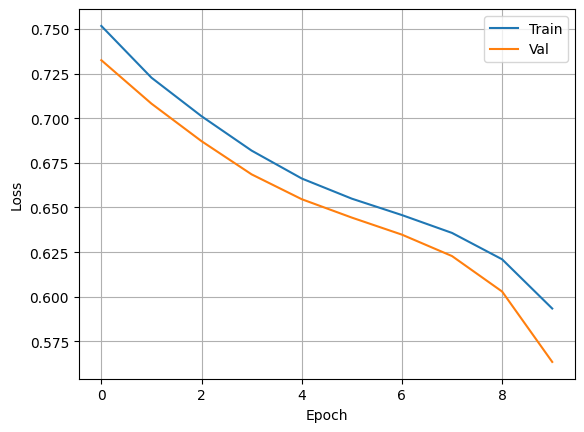

In [ ]:
x = range(len(testing1.history[0]))

plt.plot(x, testing1.history[0],label='Train')
plt.plot(x, testing1.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
testing1.predict(X_train[0])

[0.9054202438156812 0.09532788604383576 0.023477648886430506
 0.019658097534762664 0.986722750190978 0.9952107197770159
 0.8652822848163974 0.9676722820470913 0.6977642052451456
 0.9961797693946981]

## Width: 2

In [13]:
testing2 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
	verbose=1
)

testing2.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8404173241965324	Validation Loss: 0.8335945035373395
Training Loss: 0.8309840511170163	Validation Loss: 0.8265416447620149
Training Loss: 0.8259347756849517	Validation Loss: 0.8228528015106806
Training Loss: 0.8232591526395889	Validation Loss: 0.8207942899515619
Training Loss: 0.8217051550152367	Validation Loss: 0.8195133702458556
Training Loss: 0.8206896885335226	Validation Loss: 0.818617555374122
Training Loss: 0.8199389117768578	Validation Loss: 0.8179122834123217
Training Loss: 0.8193098141339271	Validation Loss: 0.8172869462186938
Training Loss: 0.8187134467364877	Validation Loss: 0.8166640560091036
Training Loss: 0.8180780746673524	Validation Loss: 0.8159712475798145


[[0.8404173241965324,
  0.8309840511170163,
  0.8259347756849517,
  0.8232591526395889,
  0.8217051550152367,
  0.8206896885335226,
  0.8199389117768578,
  0.8193098141339271,
  0.8187134467364877,
  0.8180780746673524],
 [0.8335945035373395,
  0.8265416447620149,
  0.8228528015106806,
  0.8207942899515619,
  0.8195133702458556,
  0.818617555374122,
  0.8179122834123217,
  0.8172869462186938,
  0.8166640560091036,
  0.8159712475798145]]

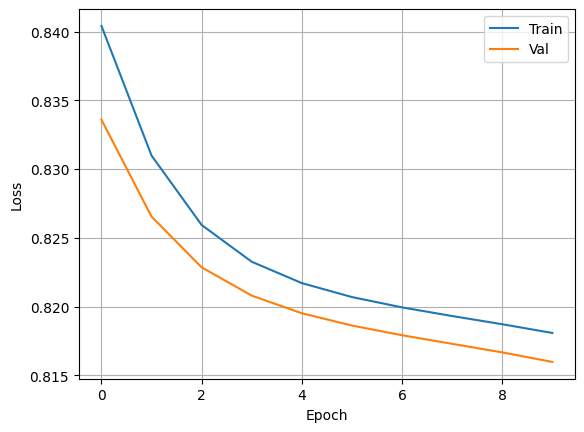

In [14]:
x = range(len(testing2.history[0]))

plt.plot(x, testing2.history[0],label='Train')
plt.plot(x, testing2.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
testing2.predict(X_train[0])

[0.9988655333843949 0.17369025129834123 0.9999935380718703
 0.9998657736786907 0.9999147963852737 0.9992267516258864
 0.9995687094159473 0.9992658627006237 0.9999722068470472
 0.9825254491945308]

## Width: 3

In [7]:
testing3 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,3,3,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
	verbose=1
)

testing3.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8998876416366757	Validation Loss: 0.899886949572397
Training Loss: 0.8998872186838166	Validation Loss: 0.8998865238901043
Training Loss: 0.8998867923771978	Validation Loss: 0.8998860948270893
Training Loss: 0.8998863626763638	Validation Loss: 0.8998856623424735
Training Loss: 0.8998859295401793	Validation Loss: 0.8998852263947289
Training Loss: 0.8998854929268562	Validation Loss: 0.8998847869416404
Training Loss: 0.8998850527939131	Validation Loss: 0.8998843439403089
Training Loss: 0.8998846090981827	Validation Loss: 0.8998838973471219
Training Loss: 0.8998841617957746	Validation Loss: 0.8998834471177541
Training Loss: 0.8998837108420807	Validation Loss: 0.8998829932071467


[[0.8998876416366757,
  0.8998872186838166,
  0.8998867923771978,
  0.8998863626763638,
  0.8998859295401793,
  0.8998854929268562,
  0.8998850527939131,
  0.8998846090981827,
  0.8998841617957746,
  0.8998837108420807],
 [0.899886949572397,
  0.8998865238901043,
  0.8998860948270893,
  0.8998856623424735,
  0.8998852263947289,
  0.8998847869416404,
  0.8998843439403089,
  0.8998838973471219,
  0.8998834471177541,
  0.8998829932071467]]

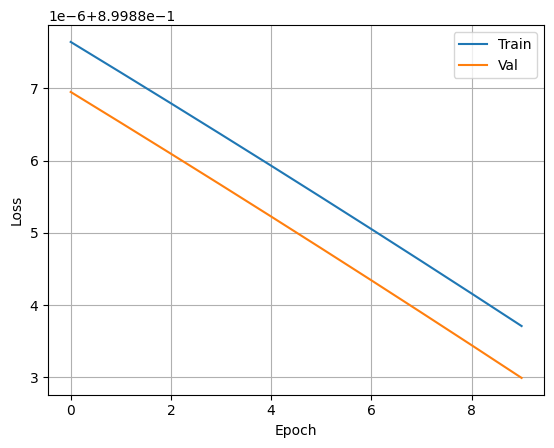

In [8]:
x = range(len(testing3.history[0]))

plt.plot(x, testing3.history[0],label='Train')
plt.plot(x, testing3.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
testing3.predict(X_train[0])

[0.9999221862142823 0.9999999726376755 0.9999999930580756
 0.9999999754978731 0.9999999073438243 0.9999998613612325
 0.9994278379495513 0.9999994478389573 0.9999999978349734
 0.9999999999122204]

## Depth: 1, Width: 2

In [7]:
testing4 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
	verbose=1
)

testing4.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.843222816977479	Validation Loss: 0.8321109540923571
Training Loss: 0.8334395962170345	Validation Loss: 0.8246125900184852
Training Loss: 0.8289957010789161	Validation Loss: 0.8211407067030133
Training Loss: 0.8269814238080345	Validation Loss: 0.8193771787820002
Training Loss: 0.8259667706945852	Validation Loss: 0.8183760727988788
Training Loss: 0.8253999100545139	Validation Loss: 0.8177535608618665
Training Loss: 0.8250559793319925	Validation Loss: 0.8173382392936777
Training Loss: 0.8248334838955645	Validation Loss: 0.8170456077767502
Training Loss: 0.8246820673801935	Validation Loss: 0.816830340643765
Training Loss: 0.8245746995186823	Validation Loss: 0.8166663794246936


[[0.843222816977479,
  0.8334395962170345,
  0.8289957010789161,
  0.8269814238080345,
  0.8259667706945852,
  0.8253999100545139,
  0.8250559793319925,
  0.8248334838955645,
  0.8246820673801935,
  0.8245746995186823],
 [0.8321109540923571,
  0.8246125900184852,
  0.8211407067030133,
  0.8193771787820002,
  0.8183760727988788,
  0.8177535608618665,
  0.8173382392936777,
  0.8170456077767502,
  0.816830340643765,
  0.8166663794246936]]

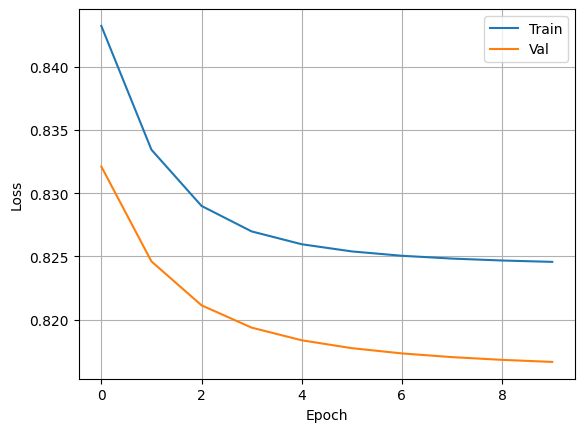

In [8]:
x = range(len(testing4.history[0]))

plt.plot(x, testing4.history[0],label='Train')
plt.plot(x, testing4.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
testing4.predict(X_train[0])

[0.999760200537507 0.18038137715246713 0.999999934120627
 0.9999967485674747 0.9999992185665187 0.9994151753712036
 0.9997189682307596 0.9997567201292954 0.9999983611859332
 0.9984281498063755]

## Depth: 2, Width: 2

In [10]:
testing5 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196, 2, 2, 10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
	verbose=1
)

testing5.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8425893951280276	Validation Loss: 0.8325425180532646
Training Loss: 0.8339254461122879	Validation Loss: 0.8253099608964124
Training Loss: 0.8292382435585819	Validation Loss: 0.8213787850753744
Training Loss: 0.8267361315026805	Validation Loss: 0.8191156134090098
Training Loss: 0.8252812792441596	Validation Loss: 0.8176769790909232
Training Loss: 0.8243325017123947	Validation Loss: 0.8166600565446716
Training Loss: 0.8236323622102196	Validation Loss: 0.8158600087267784
Training Loss: 0.8230456643089877	Validation Loss: 0.8151589236865954
Training Loss: 0.8224883468078783	Validation Loss: 0.8144747206080882
Training Loss: 0.8218930306793479	Validation Loss: 0.8137328287926775


[[0.8425893951280276,
  0.8339254461122879,
  0.8292382435585819,
  0.8267361315026805,
  0.8252812792441596,
  0.8243325017123947,
  0.8236323622102196,
  0.8230456643089877,
  0.8224883468078783,
  0.8218930306793479],
 [0.8325425180532646,
  0.8253099608964124,
  0.8213787850753744,
  0.8191156134090098,
  0.8176769790909232,
  0.8166600565446716,
  0.8158600087267784,
  0.8151589236865954,
  0.8144747206080882,
  0.8137328287926775]]

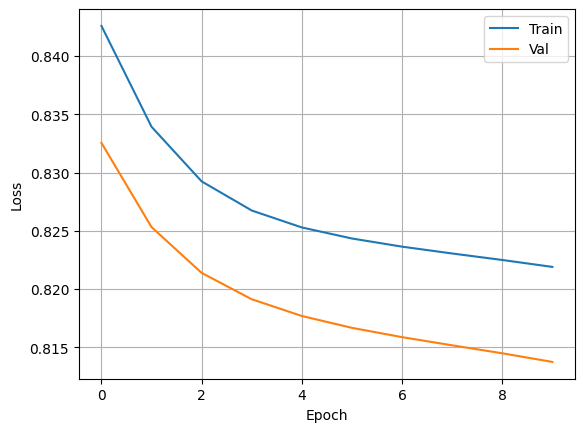

In [11]:
x = range(len(testing5.history[0]))

plt.plot(x, testing5.history[0],label='Train')
plt.plot(x, testing5.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
testing5.predict(X_train[0])

[0.9989056016708289 0.18654993178303486 0.999993724789783
 0.9998699001462871 0.9999172401139993 0.9992561721670349
 0.9995849526159047 0.9992924953420695 0.999973110654838
 0.9831339447646941]

## Depth: 3, Width: 2

In [7]:
testing6 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196, 2, 2, 10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
	verbose=1
)

testing6.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8418676275048698	Validation Loss: 0.8363530724810024
Training Loss: 0.8329425769440952	Validation Loss: 0.8298398453402525
Training Loss: 0.8281338263575981	Validation Loss: 0.8264370372107197
Training Loss: 0.825572275864573	Validation Loss: 0.824544444945333
Training Loss: 0.8240796442384101	Validation Loss: 0.8233684253122
Training Loss: 0.82309978131181	Validation Loss: 0.822541486917841
Training Loss: 0.822368692385091	Validation Loss: 0.8218801378980437
Training Loss: 0.8217466277746878	Validation Loss: 0.8212780923807063
Training Loss: 0.8211443231798419	Validation Loss: 0.8206575884879314
Training Loss: 0.8204863145294105	Validation Loss: 0.8199409412036488


[[0.8418676275048698,
  0.8329425769440952,
  0.8281338263575981,
  0.825572275864573,
  0.8240796442384101,
  0.82309978131181,
  0.822368692385091,
  0.8217466277746878,
  0.8211443231798419,
  0.8204863145294105],
 [0.8363530724810024,
  0.8298398453402525,
  0.8264370372107197,
  0.824544444945333,
  0.8233684253122,
  0.822541486917841,
  0.8218801378980437,
  0.8212780923807063,
  0.8206575884879314,
  0.8199409412036488]]

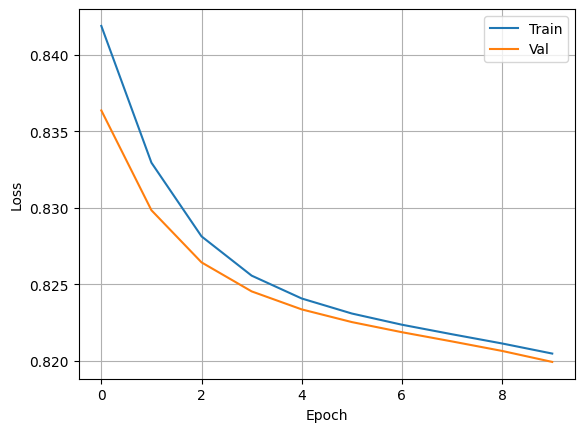

In [8]:
x = range(len(testing6.history[0]))

plt.plot(x, testing6.history[0],label='Train')
plt.plot(x, testing6.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
testing6.predict(X_train[0])

[0.9988678805158201 0.1815809249688367 0.9999932784422603
 0.9998620028565629 0.9999112461264171 0.9992411790457667
 0.9995759075691742 0.9992715188371215 0.999971766879833 0.982254123053705]

## Linear

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan


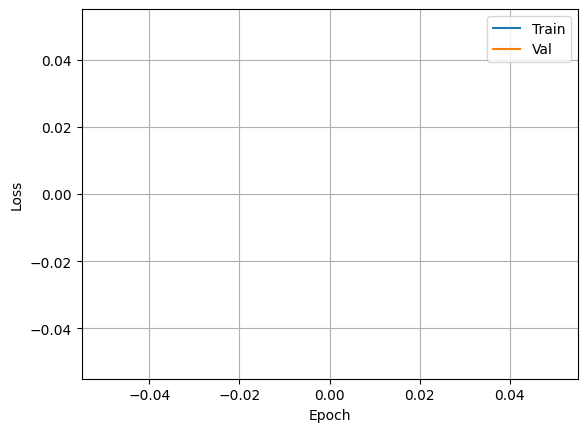

C:\Users\Canonica\AppData\Local\Temp\ipykernel_4520\605937744.py:516: RuntimeWarning: invalid value encountered in add
  self.next._neurons = np.dot(self._neurons,self.weight.T) + self.bias_weight


[nan]

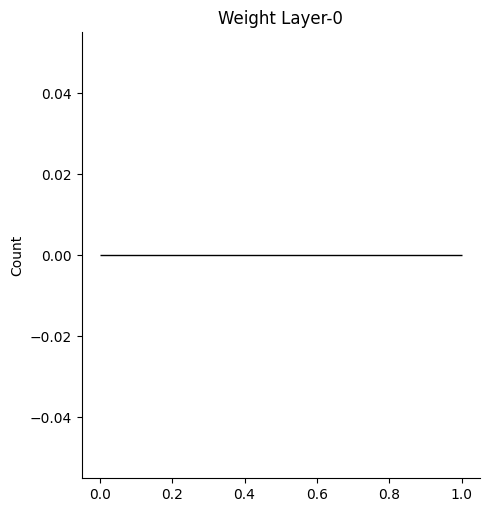

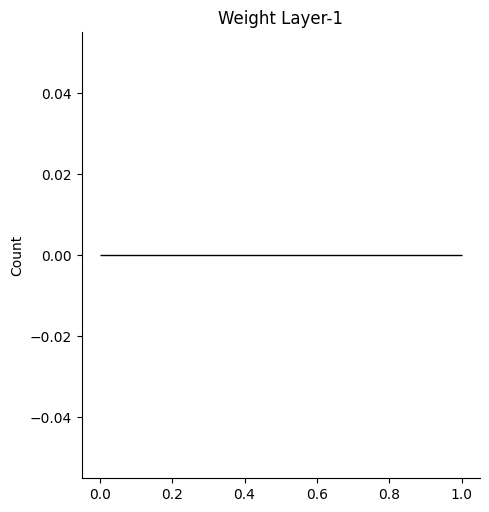

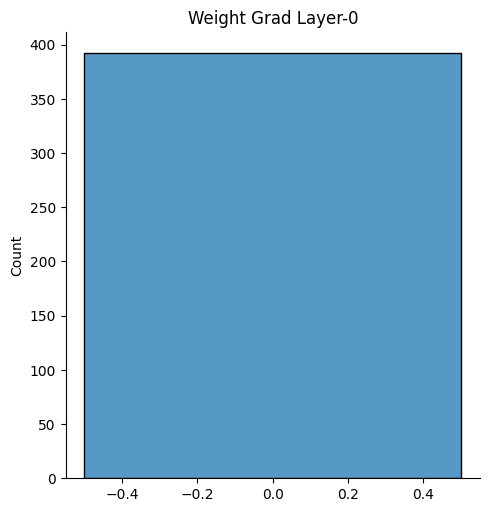

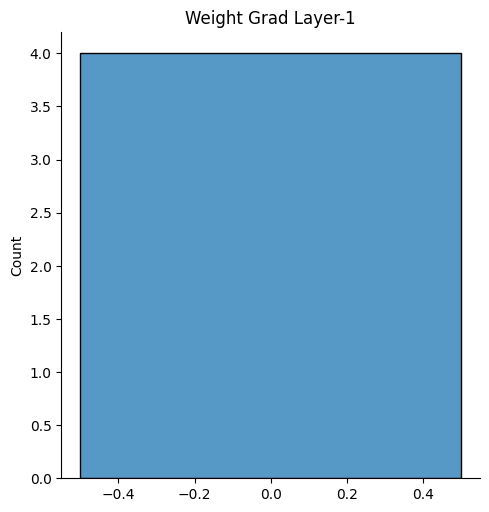

In [ ]:
activation1 = LayerWrapper(
    activation_function=["linear", "linear", "linear"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,1],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1
)

activation1.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(activation1.history[0]))

plt.plot(x, activation1.history[0],label='Train')
plt.plot(x, activation1.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

activation1.visualizeWeightDist([0,1])
activation1.visualizeWeightGradDist([0,1])

activation1.predict(X_train[0])

In [8]:
activation1.predict(X_train[0])

C:\Users\Canonica\AppData\Local\Temp\ipykernel_4520\605937744.py:516: RuntimeWarning: invalid value encountered in add
  self.next._neurons = np.dot(self._neurons,self.weight.T) + self.bias_weight


[nan]

## ReLu

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 1678948.0017331536	Validation Loss: 0.10000000000000007
Training Loss: 0.09999999999999859	Validation Loss: 0.10000000000000007
Training Loss: 0.09999999999999859	Validation Loss: 0.10000000000000007
Training Loss: 0.09999999999999859	Validation Loss: 0.10000000000000007
Training Loss: 0.09999999999999859	Validation Loss: 0.10000000000000007
Training Loss: 0.09999999999999859	Validation Loss: 0.10000000000000007
Training Loss: 0.09999999999999859	Validation Loss: 0.10000000000000007
Training Loss: 0.09999999999999859	Validation Loss: 0.10000000000000007
Training Loss: 0.09999999999999859	Validation Loss: 0.10000000000000007
Training Loss: 0.09999999999999859	Validation Loss: 0.10000000000000007


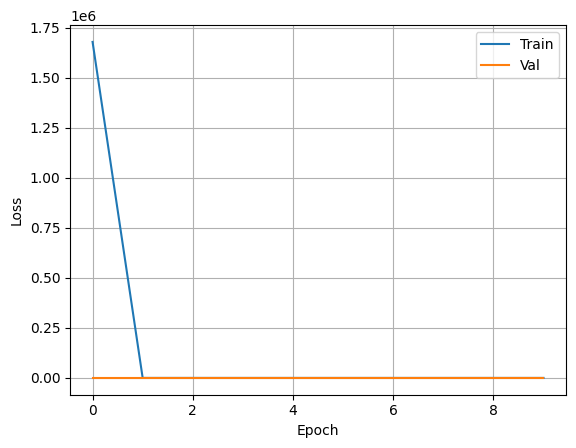

[0 0 0 0 0 0 0 0 0 0]

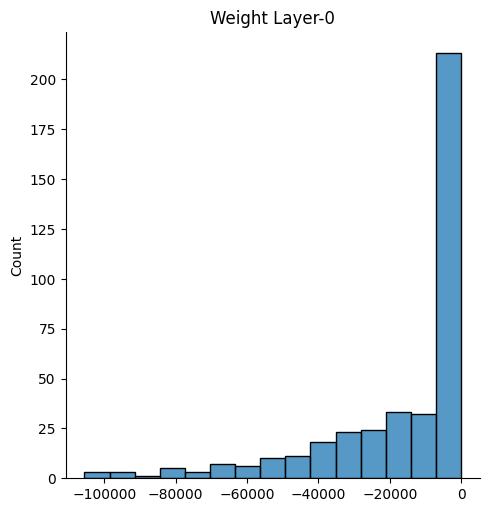

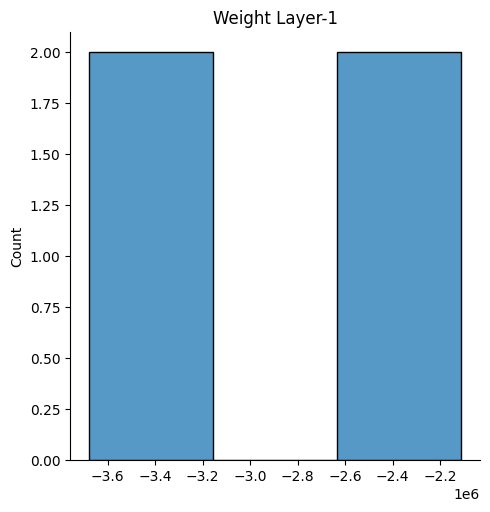

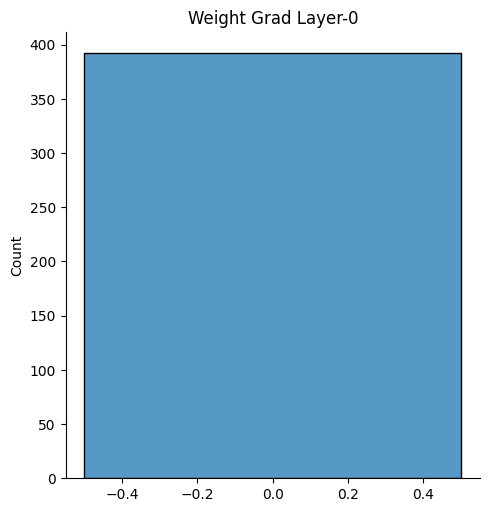

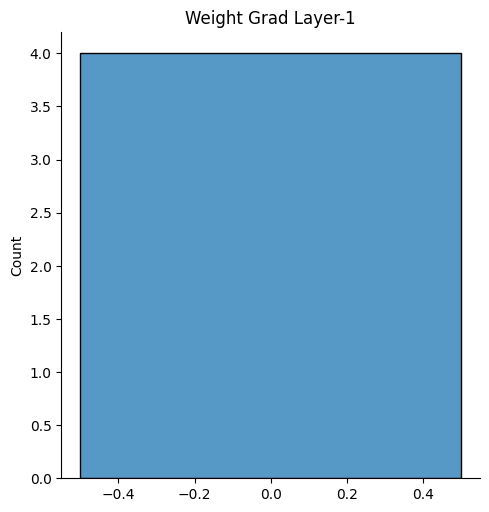

In [9]:
activation2 = LayerWrapper(
    activation_function=["relu", "relu", "relu"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1
)

activation2.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(activation2.history[0]))

plt.plot(x, activation2.history[0],label='Train')
plt.plot(x, activation2.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

activation2.visualizeWeightDist([0,1])
activation2.visualizeWeightGradDist([0,1])

activation2.predict(X_train[0])

In [10]:
activation2.predict(X_train[0])

[0 0 0 0 0 0 0 0 0 0]

## Tanh

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8200583116096397	Validation Loss: 0.8216785401502741
Training Loss: 0.8181085082940782	Validation Loss: 0.8216941607076602
Training Loss: 0.8181080713931236	Validation Loss: 0.8216936579367768
Training Loss: 0.8181073083305168	Validation Loss: 0.8216929316717833
Training Loss: 0.8181064853850162	Validation Loss: 0.8216921485447162
Training Loss: 0.8181056012865794	Validation Loss: 0.8216913035373082
Training Loss: 0.8181046486369673	Validation Loss: 0.8216903888657481
Training Loss: 0.8181036187045733	Validation Loss: 0.8216893953468083
Training Loss: 0.8181025011805525	Validation Loss: 0.8216883120903651
Training Loss: 0.8181012838032046	Validation Loss: 0.8216871260811395


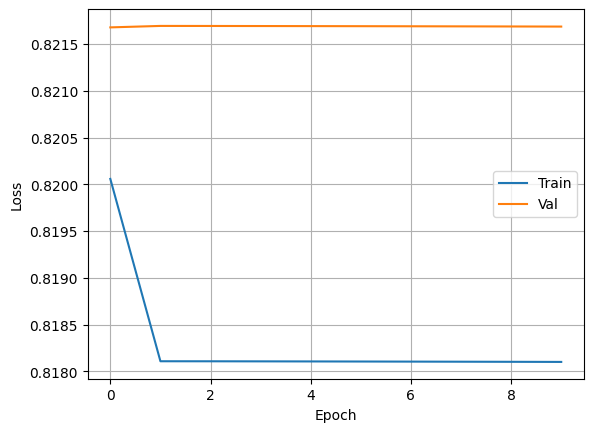

[0.9999992369285398 0.09501576391056354 0.9999999999253457
 0.9999999763318212 0.9999999865366677 0.9999997719908129
 0.9999999244641937 0.9999997244408437 0.9999999992577129
 0.999831111559498]

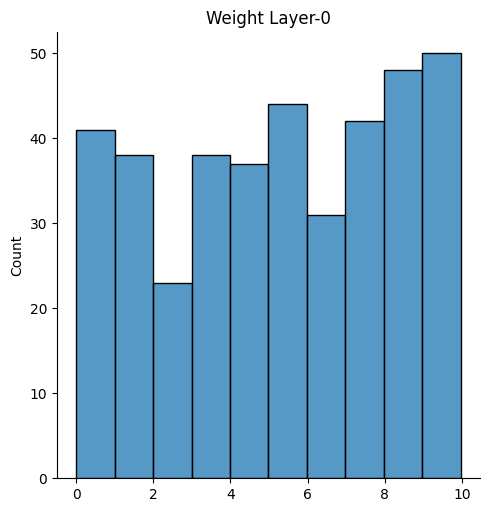

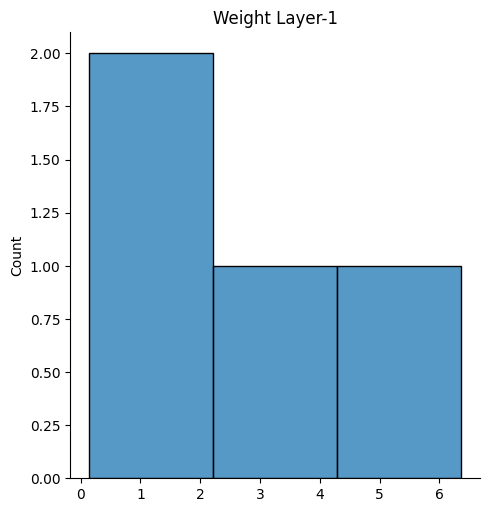

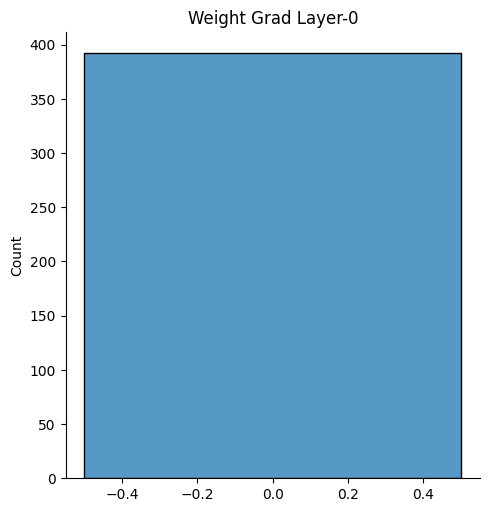

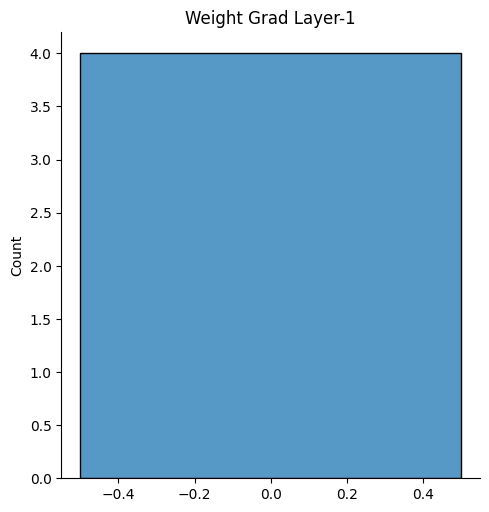

In [7]:
activation3 = LayerWrapper(
    activation_function=["hyperbolic_tangent", "hyperbolic_tangent", "hyperbolic_tangent"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1
)

activation3.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(activation3.history[0]))

plt.plot(x, activation3.history[0],label='Train')
plt.plot(x, activation3.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

activation3.visualizeWeightDist([0,1])
activation3.visualizeWeightGradDist([0,1])

activation3.predict(X_train[0])

In [8]:
activation3.predict(X_train[0])

[0.9999992369285398 0.09501576391056354 0.9999999999253457
 0.9999999763318212 0.9999999865366677 0.9999997719908129
 0.9999999244641937 0.9999997244408437 0.9999999992577129
 0.999831111559498]

## Sigmoid

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8388180403646186	Validation Loss: 0.8347466274162377
Training Loss: 0.8288023401661172	Validation Loss: 0.8279203565041175
Training Loss: 0.8234849502766243	Validation Loss: 0.8244660015687355
Training Loss: 0.8206824978513525	Validation Loss: 0.8225884351725921
Training Loss: 0.8190557514750209	Validation Loss: 0.8214387486618795
Training Loss: 0.8179906557113404	Validation Loss: 0.8206374369266024
Training Loss: 0.8172014330292802	Validation Loss: 0.8199997115745782
Training Loss: 0.816539332696359	Validation Loss: 0.8194207123805821
Training Loss: 0.815911656467644	Validation Loss: 0.8188252645528913
Training Loss: 0.8152430803335369	Validation Loss: 0.8181398355868637


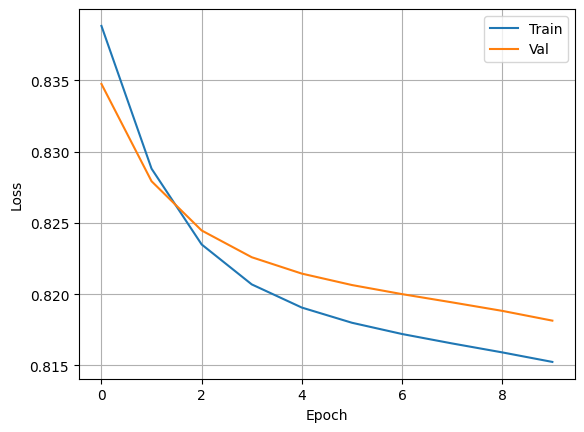

[0.9988335581018418 0.16481156754714074 0.9999933791409896
 0.9998623576539539 0.999912709872761 0.9992042533785223 0.99955623220951
 0.9992452329594267 0.999971475642283 0.9820357294515999]

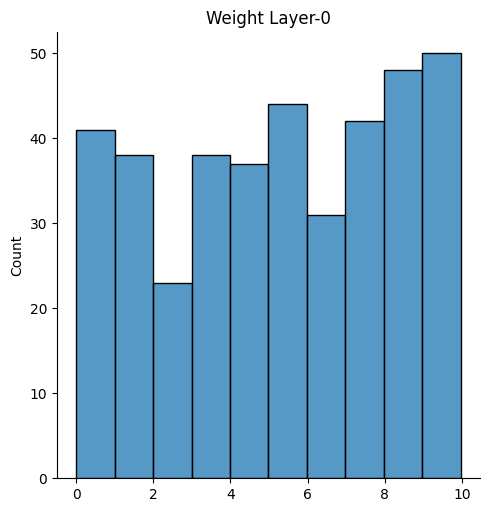

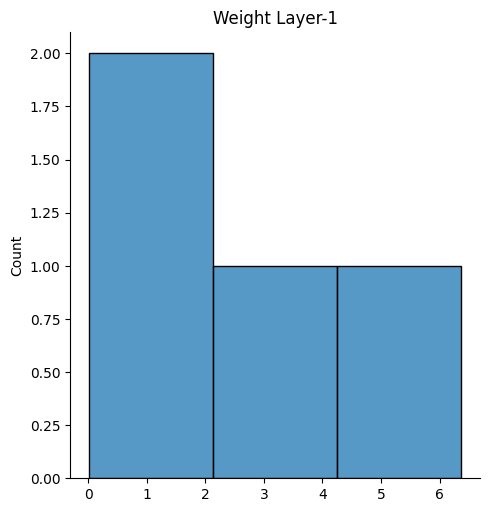

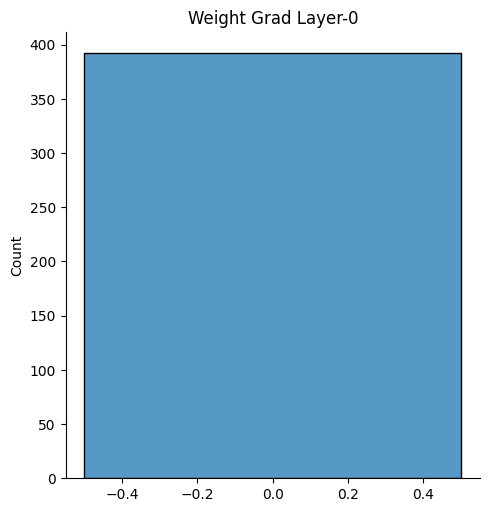

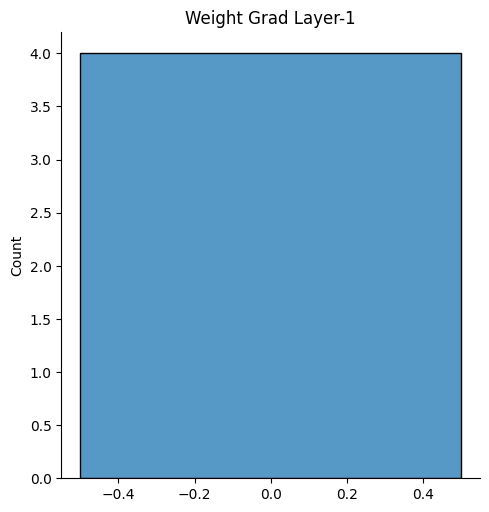

In [9]:
activation4 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1
)

activation4.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(activation4.history[0]))

plt.plot(x, activation4.history[0],label='Train')
plt.plot(x, activation4.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

activation4.visualizeWeightDist([0,1])
activation4.visualizeWeightGradDist([0,1])

activation4.predict(X_train[0])

In [10]:
activation4.predict(X_train[0])

[0.9988335581018418 0.16481156754714074 0.9999933791409896
 0.9998623576539539 0.999912709872761 0.9992042533785223 0.99955623220951
 0.9992452329594267 0.999971475642283 0.9820357294515999]

## Leaky ReLu

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\Canonica\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan
Training Loss: nan	Validation Loss: nan


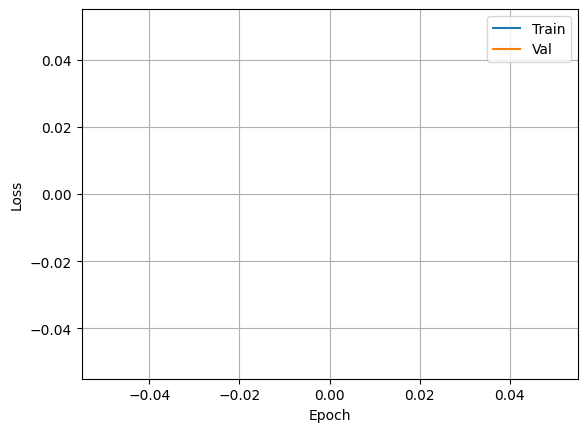

C:\Users\Canonica\AppData\Local\Temp\ipykernel_7416\2849337018.py:516: RuntimeWarning: invalid value encountered in add
  self.next._neurons = np.dot(self._neurons,self.weight.T) + self.bias_weight


[nan nan nan nan nan nan nan nan nan nan]

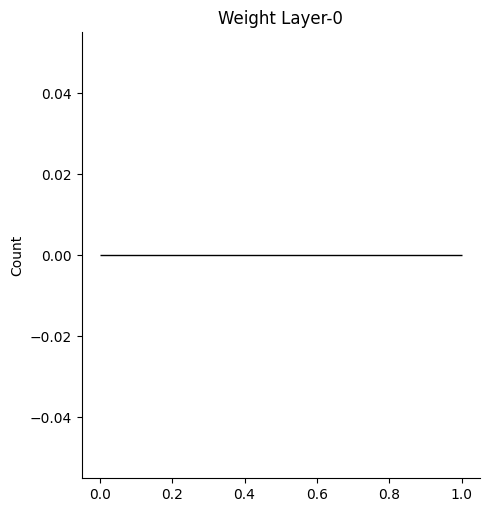

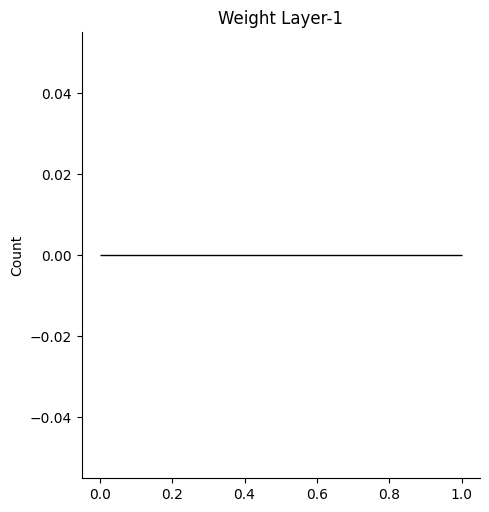

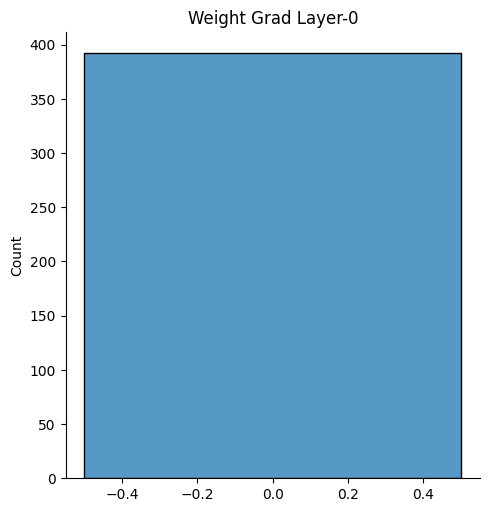

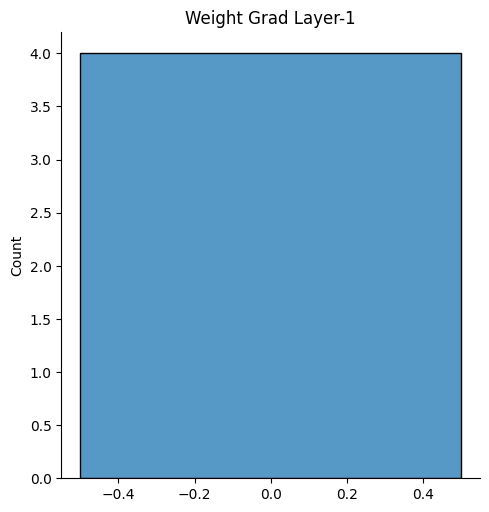

In [13]:
activation5 = LayerWrapper(
    activation_function=["leaky_relu", "leaky_relu", "leaky_relu"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1
)

activation5.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(activation5.history[0]))

plt.plot(x, activation5.history[0],label='Train')
plt.plot(x, activation5.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

activation5.visualizeWeightDist([0,1])
activation5.visualizeWeightGradDist([0,1])

activation5.predict(X_train[0])

In [ ]:
activation5.predict(X_train[0])

## Swish

In [12]:
activation6 = LayerWrapper(
    activation_function=["swish", "swish", "swish"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1
)

activation6.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(activation6.history[0]))

plt.plot(x, activation6.history[0],label='Train')
plt.plot(x, activation6.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

activation6.visualizeWeightDist([0,1])
activation6.visualizeWeightGradDist([0,1])

activation6.predict(X_train[0])

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

OverflowError: math range error

In [ ]:
activation6.predict(X_train[0])

## Learning Rate: 0.01

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8388180403646186	Validation Loss: 0.8347466274162377
Training Loss: 0.8288023401661172	Validation Loss: 0.8279203565041175
Training Loss: 0.8234849502766243	Validation Loss: 0.8244660015687355
Training Loss: 0.8206824978513525	Validation Loss: 0.8225884351725921
Training Loss: 0.8190557514750209	Validation Loss: 0.8214387486618795
Training Loss: 0.8179906557113404	Validation Loss: 0.8206374369266024
Training Loss: 0.8172014330292802	Validation Loss: 0.8199997115745782
Training Loss: 0.816539332696359	Validation Loss: 0.8194207123805821
Training Loss: 0.815911656467644	Validation Loss: 0.8188252645528913
Training Loss: 0.8152430803335369	Validation Loss: 0.8181398355868637


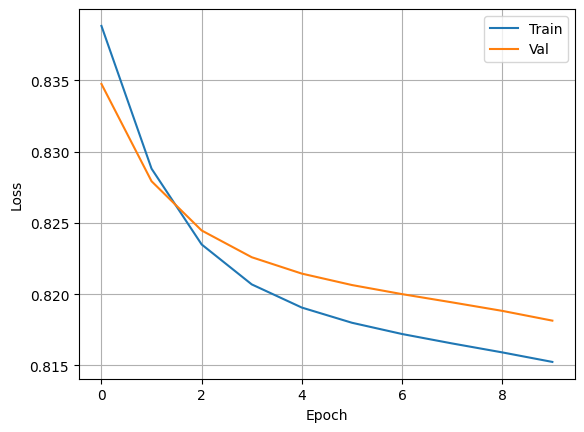

[0.9988335581018418 0.16481156754714074 0.9999933791409896
 0.9998623576539539 0.999912709872761 0.9992042533785223 0.99955623220951
 0.9992452329594267 0.999971475642283 0.9820357294515999]

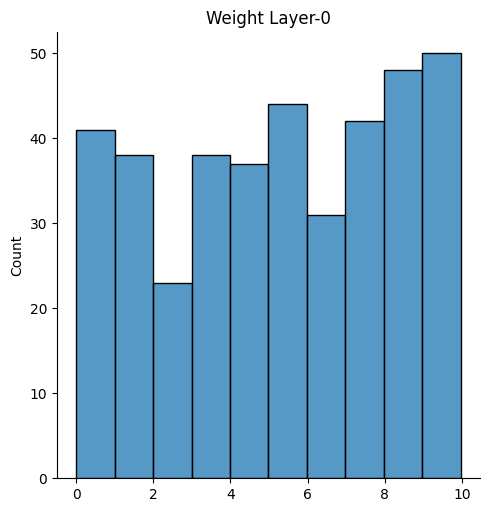

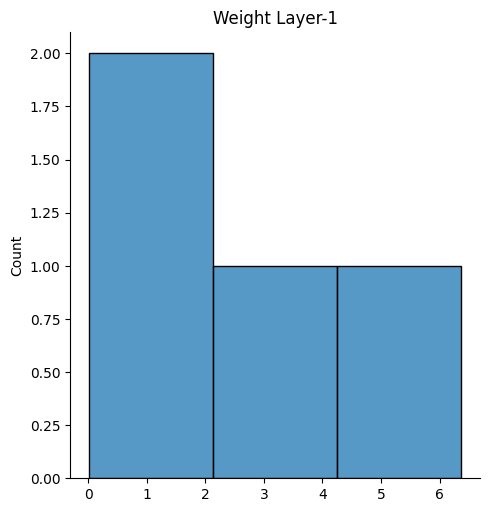

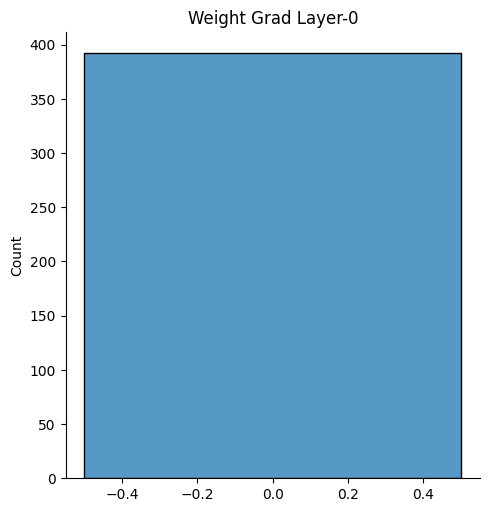

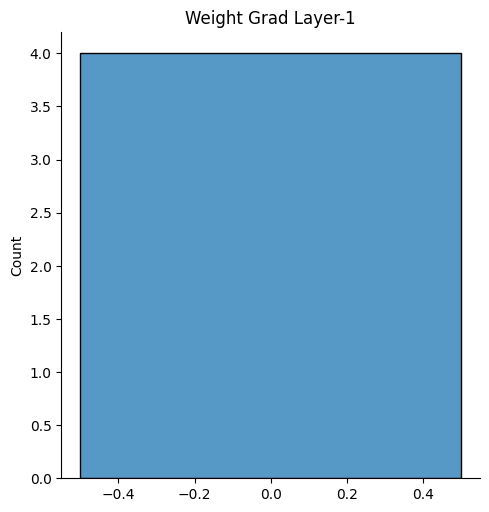

In [13]:
lr1 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1
)

lr1.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(lr1.history[0]))

plt.plot(x, lr1.history[0],label='Train')
plt.plot(x, lr1.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

lr1.visualizeWeightDist([0,1])
lr1.visualizeWeightGradDist([0,1])

lr1.predict(X_train[0])

In [14]:
lr1.predict(X_train[0])

[0.9988335581018418 0.16481156754714074 0.9999933791409896
 0.9998623576539539 0.999912709872761 0.9992042533785223 0.99955623220951
 0.9992452329594267 0.999971475642283 0.9820357294515999]

## Learning Rate: 0.05

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8281211279290112	Validation Loss: 0.8268392674668676
Training Loss: 0.8187629362171216	Validation Loss: 0.824032421455932
Training Loss: 0.8131186254211437	Validation Loss: 0.8110768083045325
Training Loss: 0.7646203827090051	Validation Loss: 0.7350764570696984
Training Loss: 0.6623939182737217	Validation Loss: 0.47486323429454175
Training Loss: 0.20743997245360649	Validation Loss: 0.09993986170369219
Training Loss: 0.09736287816615473	Validation Loss: 0.09562586402294447
Training Loss: 0.0956639699519464	Validation Loss: 0.09515603028608208
Training Loss: 0.09536827010934149	Validation Loss: 0.09502801430190067
Training Loss: 0.09525959498813187	Validation Loss: 0.09496779713551623


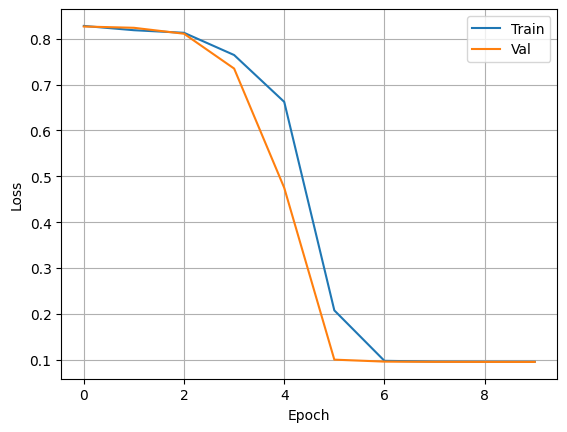

[0.019304279370466856 4.9107783603228125e-05 0.09945124381298837
 0.015608075574737616 0.007747879239547508 0.09577648924769408
 0.12096426362502526 0.05428092761120696 0.11925588337025876
 0.0003577161037074894]

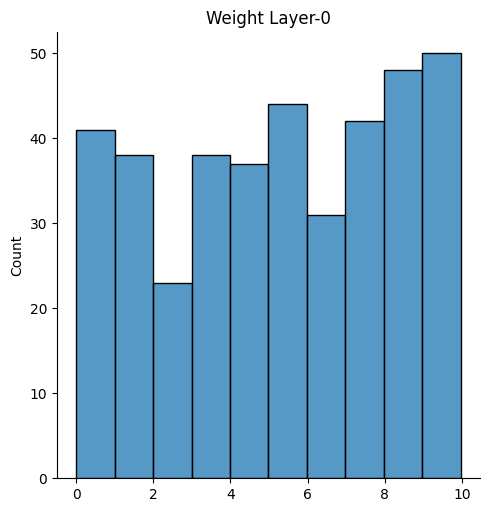

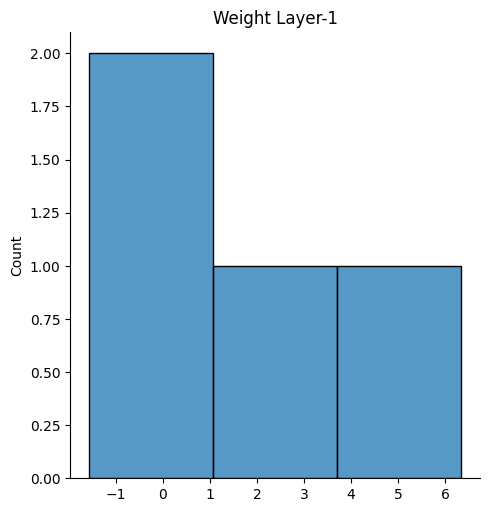

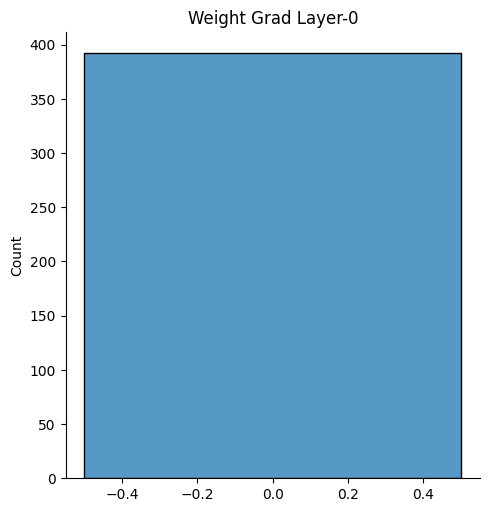

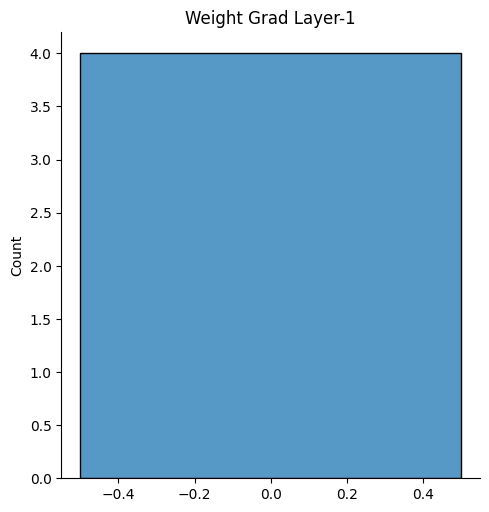

In [7]:
lr2 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.05,
    max_epoch=10,
    verbose=1
)

lr2.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(lr2.history[0]))

plt.plot(x, lr2.history[0],label='Train')
plt.plot(x, lr2.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

lr2.visualizeWeightDist([0,1])
lr2.visualizeWeightGradDist([0,1])

lr2.predict(X_train[0])

In [8]:
lr2.predict(X_train[0])

[0.019304279370466856 4.9107783603228125e-05 0.09945124381298837
 0.015608075574737616 0.007747879239547508 0.09577648924769408
 0.12096426362502526 0.05428092761120696 0.11925588337025876
 0.0003577161037074894]

## Learning Rate: 0.1

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8235036942859275	Validation Loss: 0.8240109267240961
Training Loss: 0.790099976762413	Validation Loss: 0.7356591912013064
Training Loss: 0.4470206354747624	Validation Loss: 0.10003082243179075
Training Loss: 0.09657539410447989	Validation Loss: 0.09518417854664439
Training Loss: 0.0953487061711815	Validation Loss: 0.09499833027839887
Training Loss: 0.09520695219290325	Validation Loss: 0.09491735937848349
Training Loss: 0.09511733083395048	Validation Loss: 0.09484335479785344
Training Loss: 0.0950345944484885	Validation Loss: 0.0947695557296633
Training Loss: 0.09495362442445698	Validation Loss: 0.09469636241849523
Training Loss: 0.09487383453586559	Validation Loss: 0.09462460076105572


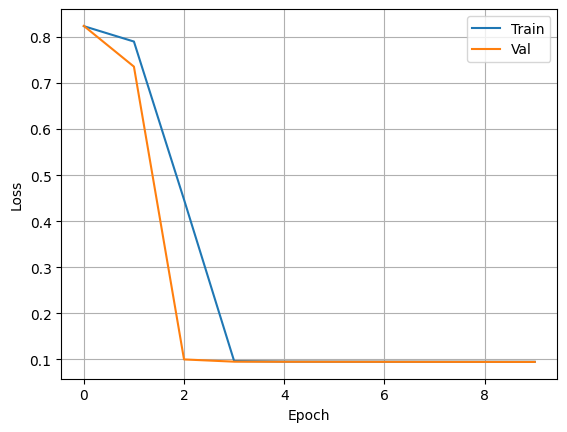

[0.024474033257639694 5.263594562191627e-05 0.09808002379873973
 0.01893441602407903 0.009155228029788175 0.09756930716290554
 0.1149501801573753 0.07122853662732336 0.10547294537099793
 0.000384701991450958]

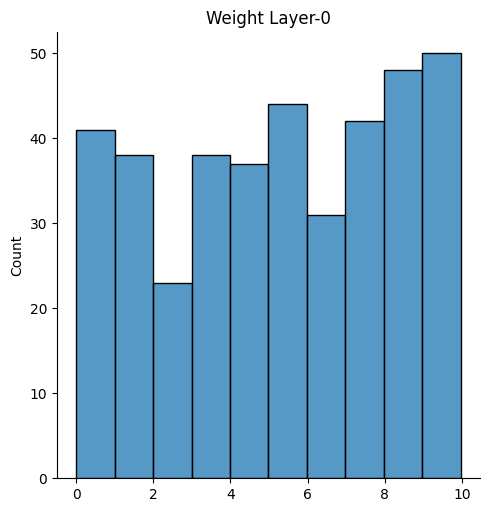

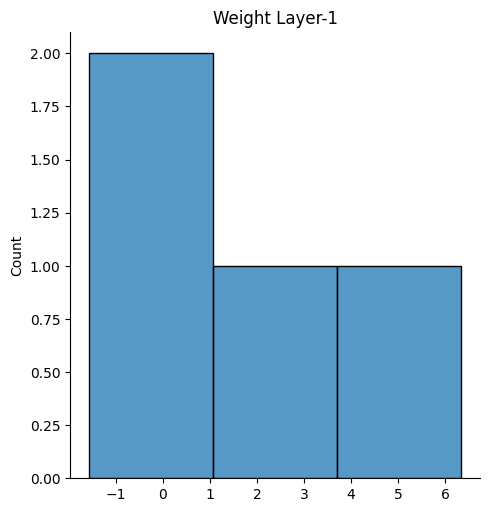

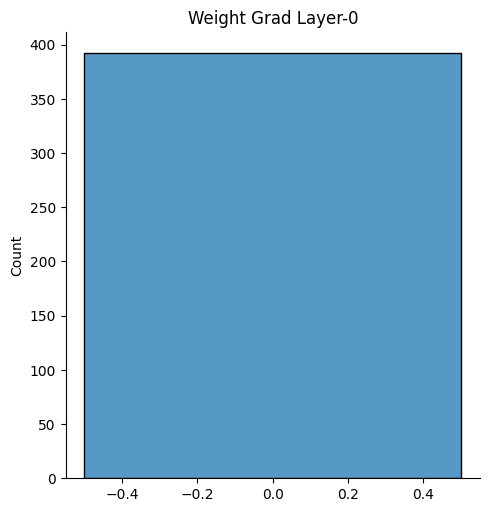

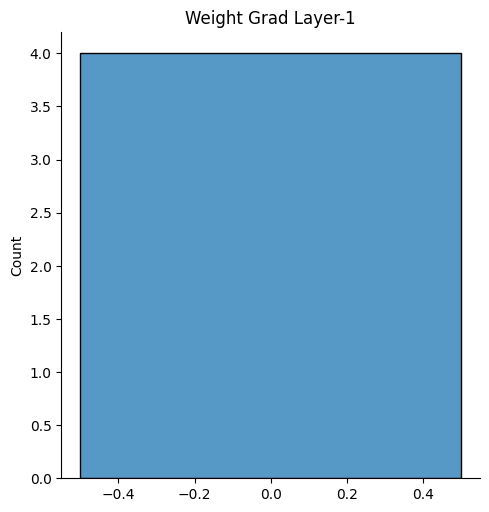

In [9]:
lr3 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.1,
    max_epoch=10,
    verbose=1
)

lr3.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(lr3.history[0]))

plt.plot(x, lr3.history[0],label='Train')
plt.plot(x, lr3.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

lr3.visualizeWeightDist([0,1])
lr3.visualizeWeightGradDist([0,1])

lr3.predict(X_train[0])

In [10]:
lr3.predict(X_train[0])

[0.024474033257639694 5.263594562191627e-05 0.09808002379873973
 0.01893441602407903 0.009155228029788175 0.09756930716290554
 0.1149501801573753 0.07122853662732336 0.10547294537099793
 0.000384701991450958]

## Uniform Init

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8421750978575131	Validation Loss: 0.8344318843479667
Training Loss: 0.8333662208365042	Validation Loss: 0.8275525326747558
Training Loss: 0.8286096567777266	Validation Loss: 0.8238823299971938
Training Loss: 0.8260721497804149	Validation Loss: 0.8218023260423067
Training Loss: 0.8245940383991119	Validation Loss: 0.8204929192628169
Training Loss: 0.8236258239800478	Validation Loss: 0.8195684372581938
Training Loss: 0.8229062531158172	Validation Loss: 0.8188343233500516
Training Loss: 0.8222973676828228	Validation Loss: 0.8181779951509437
Training Loss: 0.8217119069171909	Validation Loss: 0.8175187706767433
Training Loss: 0.8210775362786653	Validation Loss: 0.8167791913274519


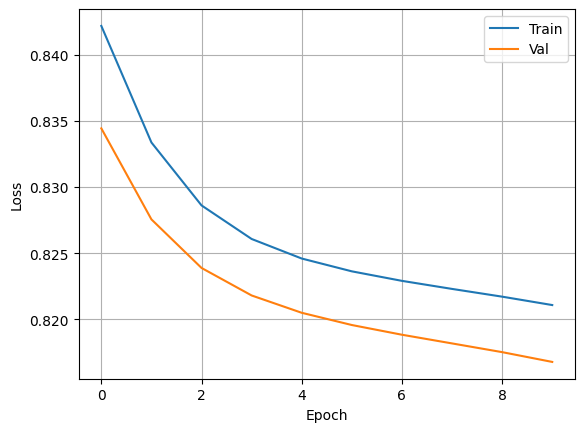

[0.9988820037675509 0.1837364802573301 0.9999934433483534
 0.999864943816418 0.9999134592055328 0.9992473844828523
 0.9995796375926924 0.9992797817509209 0.9999722714939587
 0.9825884075990295]

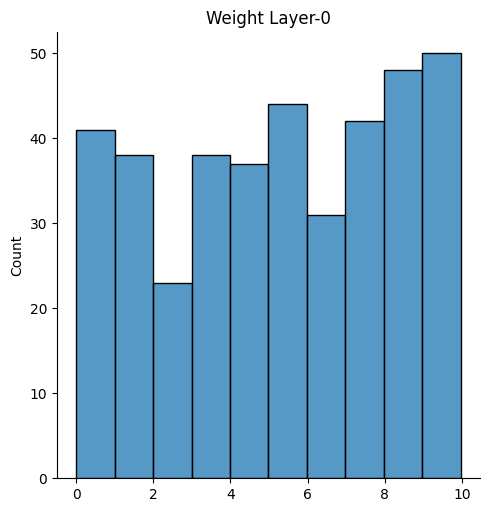

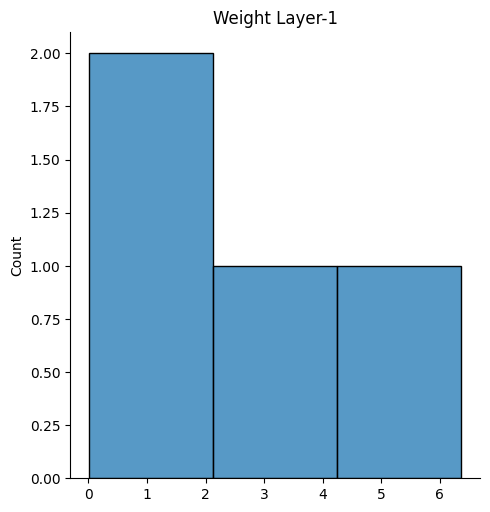

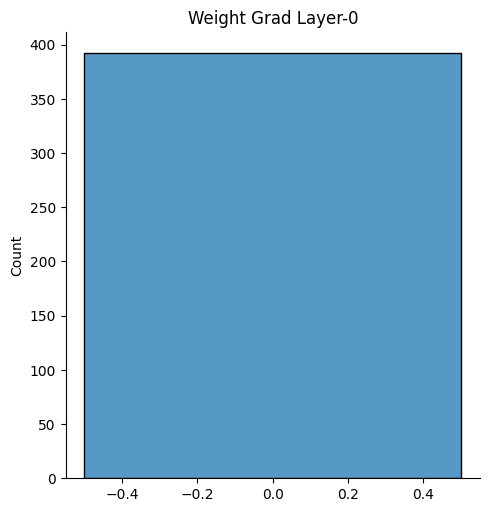

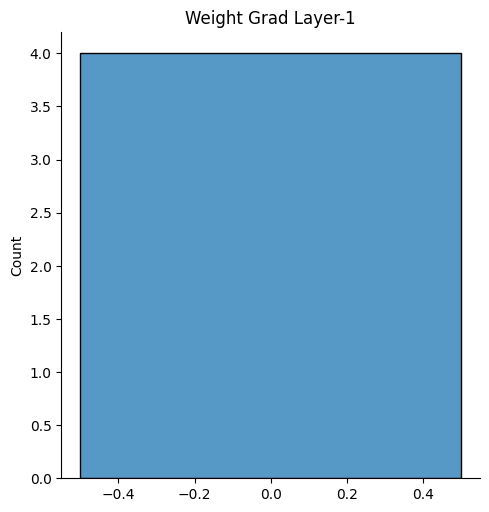

In [7]:
init1 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1
)

init1.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(init1.history[0]))

plt.plot(x, init1.history[0],label='Train')
plt.plot(x, init1.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

init1.visualizeWeightDist([0,1])
init1.visualizeWeightGradDist([0,1])

init1.predict(X_train[0])

In [8]:
init1.predict(X_train[0])

[0.9988820037675509 0.1837364802573301 0.9999934433483534
 0.999864943816418 0.9999134592055328 0.9992473844828523
 0.9995796375926924 0.9992797817509209 0.9999722714939587
 0.9825884075990295]

## Normal Init

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.6395182692963636	Validation Loss: 0.636121808018499
Training Loss: 0.6275884703536097	Validation Loss: 0.6208572493266094
Training Loss: 0.6087559205630152	Validation Loss: 0.6013199097476685
Training Loss: 0.590972916485215	Validation Loss: 0.5883745800721546
Training Loss: 0.5810201434367867	Validation Loss: 0.5820250658495965
Training Loss: 0.5757224704314277	Validation Loss: 0.5780855216322628
Training Loss: 0.5718121708974414	Validation Loss: 0.5744280081875798
Training Loss: 0.5675931639117875	Validation Loss: 0.5696834309463366
Training Loss: 0.5615302362301596	Validation Loss: 0.5620025807110461
Training Loss: 0.5511877827418324	Validation Loss: 0.5483138705008007


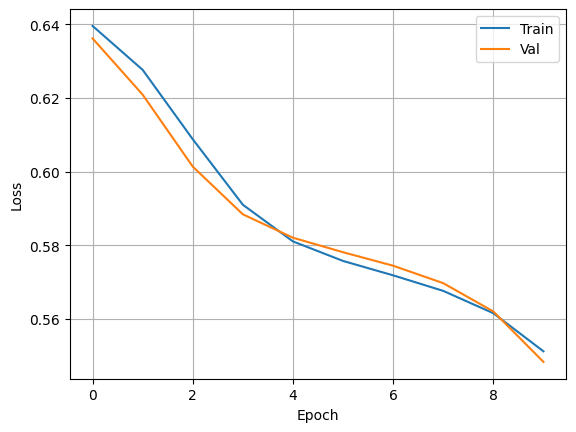

[0.9996642228442889 0.9999996147692768 0.9984530667920547
 0.9999999999994984 6.380740851456868e-05 0.7796902535083416
 3.6201130358438996e-07 5.884344353961693e-05 0.1225619106719265
 0.9999999993466564]

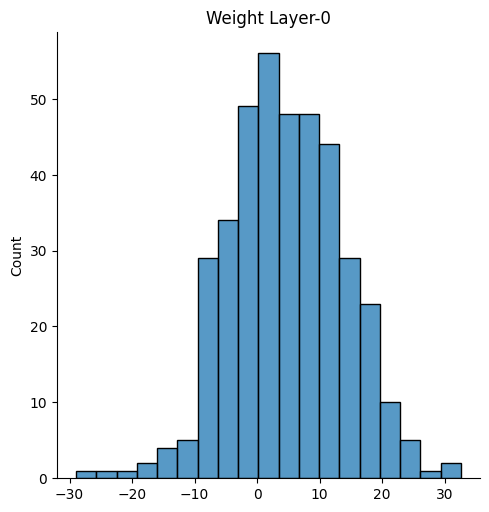

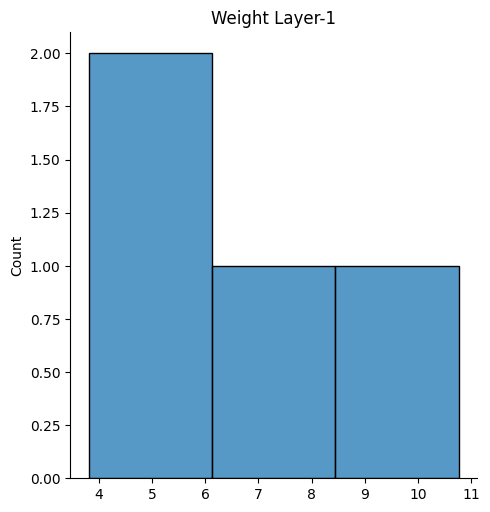

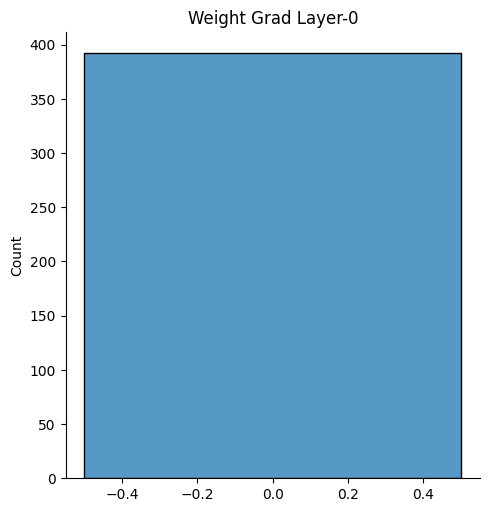

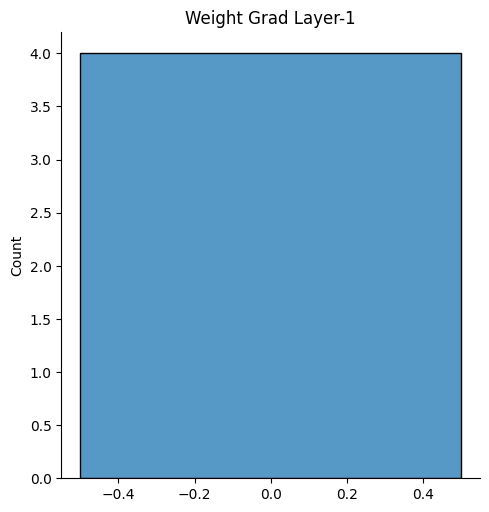

In [9]:
init2 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["normal", "normal", "normal"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1
)

init2.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(init2.history[0]))

plt.plot(x, init2.history[0],label='Train')
plt.plot(x, init2.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

init2.visualizeWeightDist([0,1])
init2.visualizeWeightGradDist([0,1])

init2.predict(X_train[0])

In [10]:
init2.predict(X_train[0])

[0.9996642228442889 0.9999996147692768 0.9984530667920547
 0.9999999999994984 6.380740851456868e-05 0.7796902535083416
 3.6201130358438996e-07 5.884344353961693e-05 0.1225619106719265
 0.9999999993466564]

## Zero Init

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.1528959133535606	Validation Loss: 0.1105527717299298
Training Loss: 0.10190688794157951	Validation Loss: 0.09654461443813732
Training Loss: 0.09443308609930394	Validation Loss: 0.09290806076472492
Training Loss: 0.09211067330025316	Validation Loss: 0.09151186930571813
Training Loss: 0.09113318160763878	Validation Loss: 0.09086069021650842
Training Loss: 0.09065099955048472	Validation Loss: 0.09052017515287593
Training Loss: 0.09038884835486378	Validation Loss: 0.09032841700282888
Training Loss: 0.09023665310228113	Validation Loss: 0.09021478932215382
Training Loss: 0.0901439964502483	Validation Loss: 0.0901449763524635
Training Loss: 0.09008549196301276	Validation Loss: 0.09010095117764515


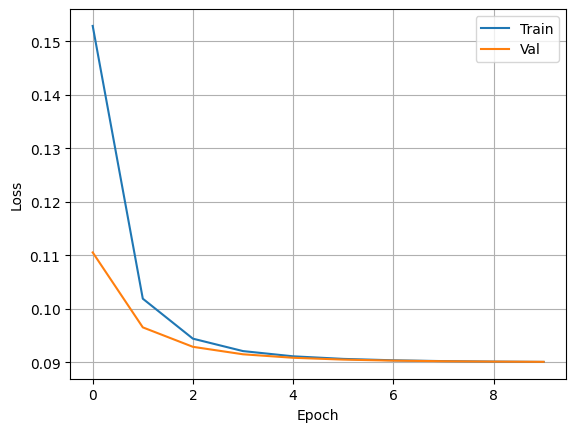

[0.10831580466745393 0.11202044101927859 0.10872786520372411
 0.11044720206028254 0.10895239018958837 0.10766817121770077
 0.11064727591939803 0.1106515855875233 0.1082804199472196
 0.10896473084243084]

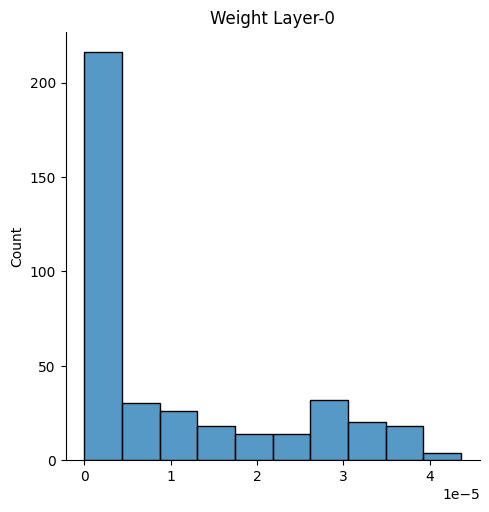

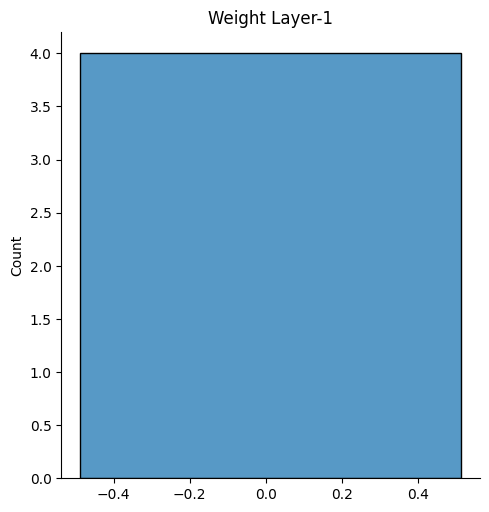

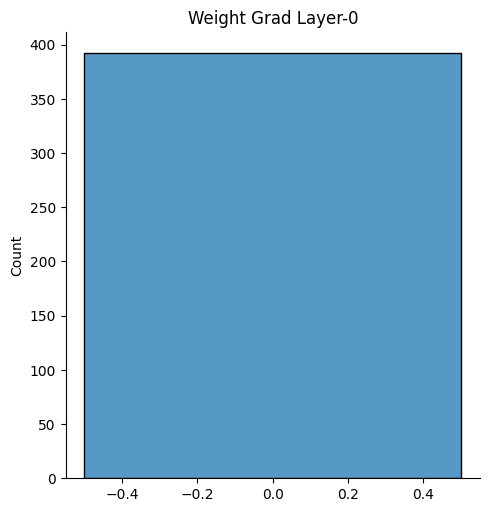

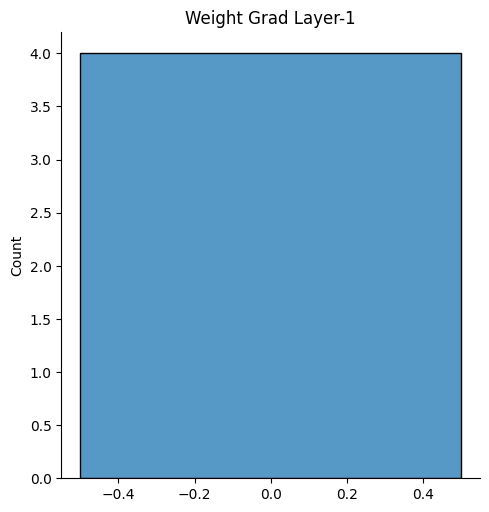

In [7]:
init3 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["zero", "zero", "zero"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1
)

init3.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(init3.history[0]))

plt.plot(x, init3.history[0],label='Train')
plt.plot(x, init3.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

init3.visualizeWeightDist([0,1])
init3.visualizeWeightGradDist([0,1])

init3.predict(X_train[0])

In [ ]:
init3.predict(X_train[0])

[0.10831580466745393 0.11202044101927859 0.10872786520372411
 0.11044720206028254 0.10895239018958837 0.10766817121770077
 0.11064727591939803 0.1106515855875233 0.1082804199472196
 0.10896473084243084]

## Unregularized

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8413795174595148	Validation Loss: 0.831726267175228
Training Loss: 0.8322847045184931	Validation Loss: 0.8243145768624806
Training Loss: 0.8273967102128333	Validation Loss: 0.8203315113024401
Training Loss: 0.8247982102479069	Validation Loss: 0.8180533114934787
Training Loss: 0.8232859026903755	Validation Loss: 0.8166066032280676
Training Loss: 0.8222946088047276	Validation Loss: 0.8155796792038535
Training Loss: 0.8215570821193896	Validation Loss: 0.8147641607191558
Training Loss: 0.8209324959909963	Validation Loss: 0.8140391319367912
Training Loss: 0.8203316553370958	Validation Loss: 0.8133179641936171
Training Loss: 0.8196802386213909	Validation Loss: 0.8125177789827562


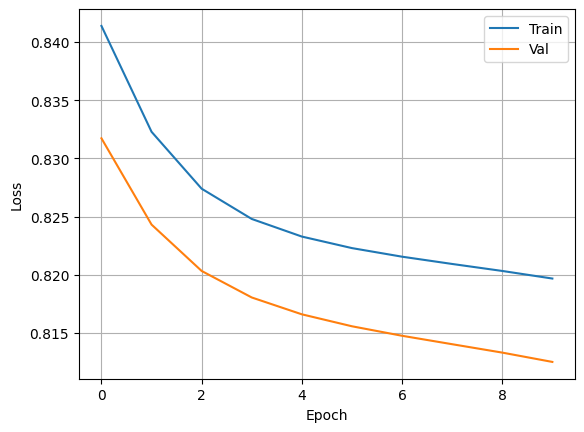

[0.9988657618276074 0.17885700320881984 0.999993353210931
 0.9998630538163502 0.9999122711727393 0.9992361304975846
 0.9995733944470458 0.9992692709014661 0.9999718777775783
 0.9823234761023715]


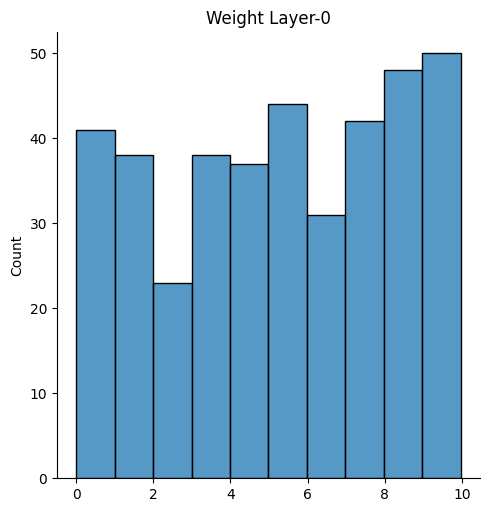

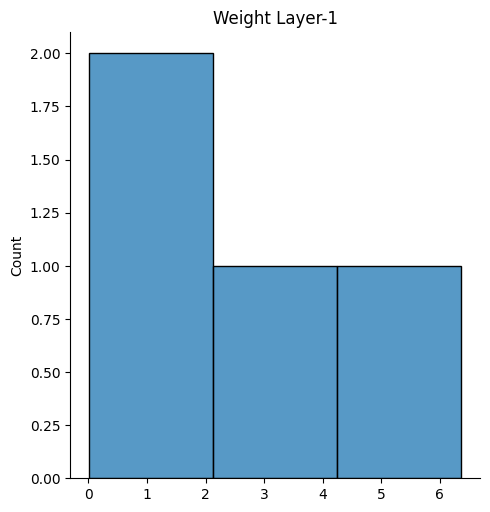

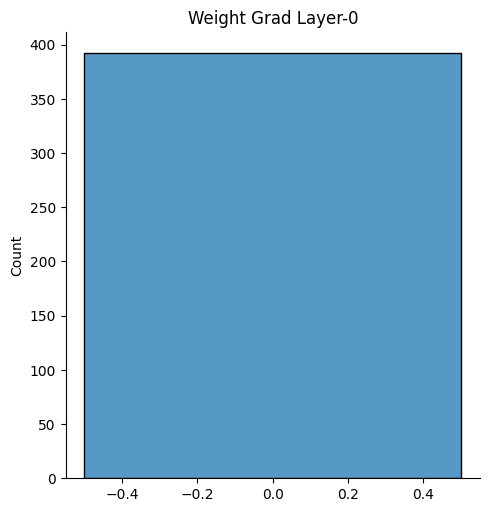

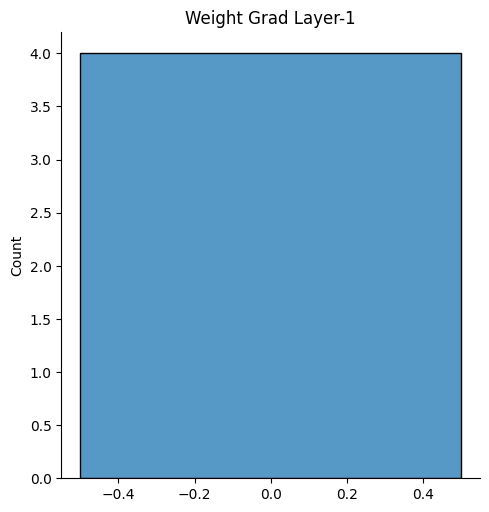

In [9]:
reg1 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1
)

reg1.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(reg1.history[0]))

plt.plot(x, reg1.history[0],label='Train')
plt.plot(x, reg1.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

reg1.visualizeWeightDist([0,1])
reg1.visualizeWeightGradDist([0,1])

print(reg1.predict(X_train[0]))

## Regularisasi L1

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8413795174595148	Validation Loss: 0.831726267175228
Training Loss: 0.8322847045184931	Validation Loss: 0.8243145768624806
Training Loss: 0.8273967102128333	Validation Loss: 0.8203315113024401
Training Loss: 0.8247982102479069	Validation Loss: 0.8180533114934787
Training Loss: 0.8232859026903755	Validation Loss: 0.8166066032280676
Training Loss: 0.8222946088047276	Validation Loss: 0.8155796792038535
Training Loss: 0.8215570821193896	Validation Loss: 0.8147641607191558
Training Loss: 0.8209324959909963	Validation Loss: 0.8140391319367912
Training Loss: 0.8203316553370958	Validation Loss: 0.8133179641936171
Training Loss: 0.8196802386213909	Validation Loss: 0.8125177789827562


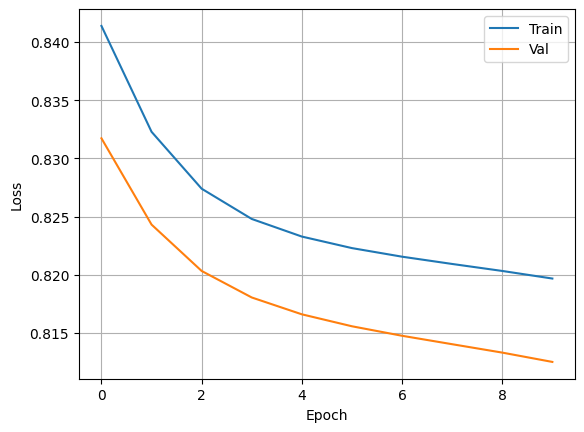

[0.9988657618276074 0.17885700320881984 0.999993353210931
 0.9998630538163502 0.9999122711727393 0.9992361304975846
 0.9995733944470458 0.9992692709014661 0.9999718777775783
 0.9823234761023715]


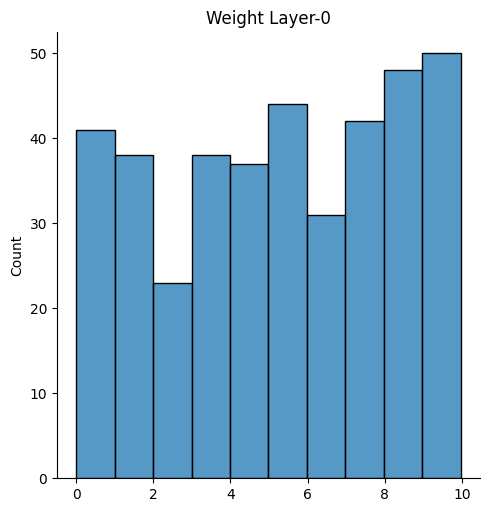

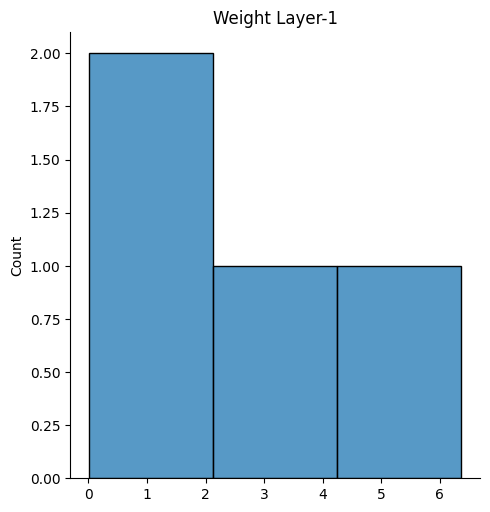

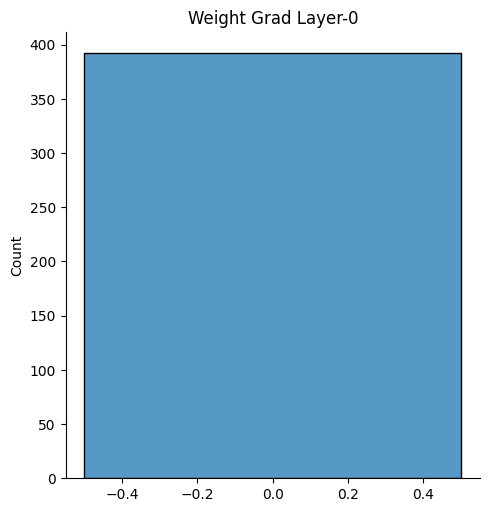

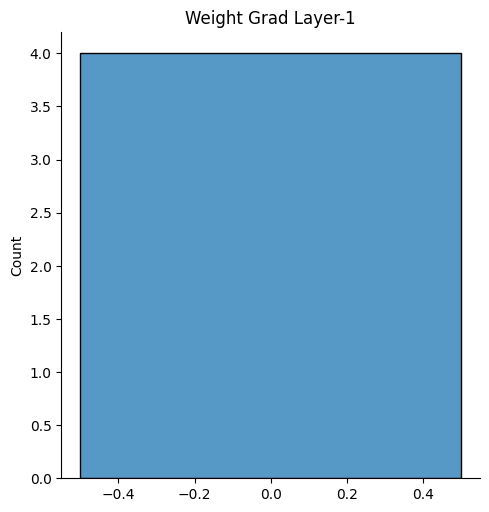

In [10]:
reg2 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1,
    regularization_type="L1",
    regularization_lambda=0.5
)

reg2.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(reg2.history[0]))

plt.plot(x, reg2.history[0],label='Train')
plt.plot(x, reg2.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

reg2.visualizeWeightDist([0,1])
reg2.visualizeWeightGradDist([0,1])

print(reg2.predict(X_train[0]))

## Regularisasi L2

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Loss: 0.8406003269925746	Validation Loss: 0.8361571535935116
Training Loss: 0.8312304342264253	Validation Loss: 0.8296053248414991
Training Loss: 0.8262083334355969	Validation Loss: 0.8262416675751599
Training Loss: 0.8235425482781255	Validation Loss: 0.8243985142557732
Training Loss: 0.8219904789685311	Validation Loss: 0.8232670388890462
Training Loss: 0.8209720091828181	Validation Loss: 0.822479119602531
Training Loss: 0.8202137418784902	Validation Loss: 0.8218534649131449
Training Loss: 0.8195717635294684	Validation Loss: 0.8212864152373921
Training Loss: 0.8189548546998132	Validation Loss: 0.8207031493462207
Training Loss: 0.8182868085571174	Validation Loss: 0.8200298403588951


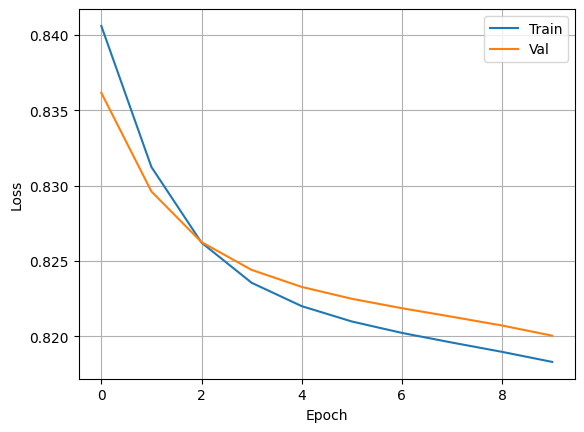

[0.9988508812895788 0.17446833098237355 0.9999932754425181
 0.9998613975189197 0.9999112478830647 0.9992256994254551
 0.9995675246328923 0.9992594117501176 0.9999715269182445
 0.9820887107565537]


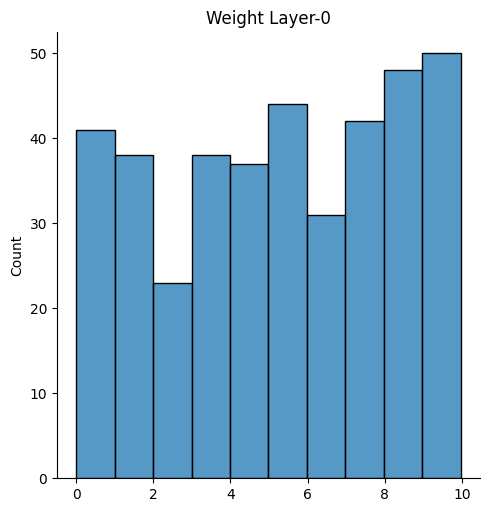

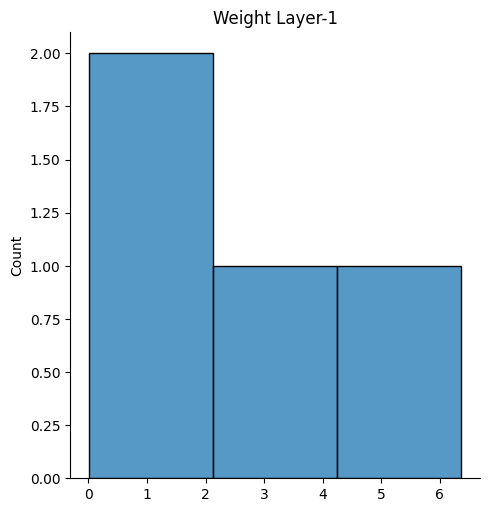

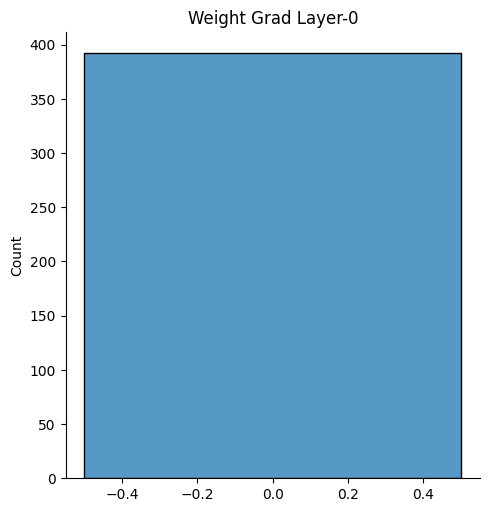

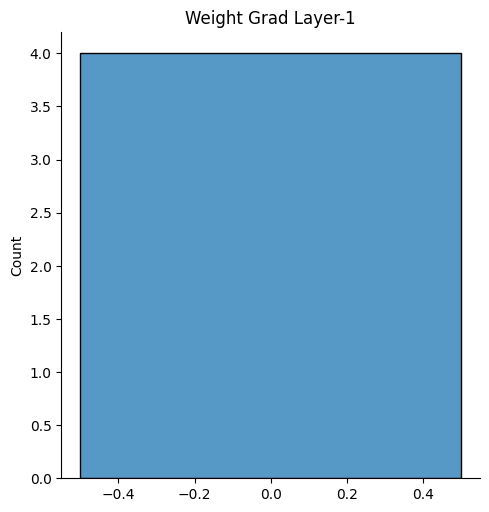

In [7]:
reg3 = LayerWrapper(
    activation_function=["sigmoid", "sigmoid", "sigmoid"],
    weight_initialization=["uniform", "uniform", "uniform"],
    loss_function="mse",
    layer_neuron_width=[196,2,2,10],
    batch_size=25,
    learning_rate=0.01,
    max_epoch=10,
    verbose=1,
    regularization_type="L2",
    regularization_lambda=0.5
)

reg3.fit(
    Y_train=y_train_,
    X_train=X_train,
    X_val=X_test,
    Y_val=y_test_,
)

x = range(len(reg3.history[0]))

plt.plot(x, reg3.history[0],label='Train')
plt.plot(x, reg3.history[1], label='Val')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('')
plt.legend()
plt.grid(True)
plt.show()

reg3.visualizeWeightDist([0,1])
reg3.visualizeWeightGradDist([0,1])

print(reg3.predict(X_train[0]))